## Exploratory Data Analysis & Preprocessing for Beauty Product Demand  

### Introduction
This notebook walks through the first steps of exploring and preparing the data for forecasting global beauty product demand. It gets the dataset ready for building machine learning and deep learning models later on.


### Dataset Reference

The base dataset is from Kaggle:  
**Most Used Beauty Cosmetics Products in the World**  
Source: [https://www.kaggle.com/datasets/waqi786/most-used-beauty-cosmetics-products-in-the-world](https://www.kaggle.com/datasets/waqi786/most-used-beauty-cosmetics-products-in-the-world)

This dataset has been extended with additional synthetic features to simulate real-world business scenarios.

### Project Goals
- Understand the structure and contents of the raw dataset  
- Clean, transform, and enrich the data to make it modeling-ready  
- Explore demand patterns across products, regions, and sales channels  
- Engineer meaningful features to support both traditional and ML-based forecasting models  
- Apply clustering to identify SKU-level behavioral segments  

###  Table of Contents

1. **Setup** – Imports & Data Loading  
2. **EDA** – Overview, Trends, Column Exploration  
3. **Preprocessing** – Data Split, Pseudo_SKU_ID, Clustering  
4. **Feature Engineering** – New Features, Missing Values, Skewness  
5. **Data Cleanup** – Rare Categories, Encoding, Dropping Columns  
6. **Final Steps** – Column Check, Export Datasets

## <span style="color:blue">1. SETUP</span>

### Importing Python Modules

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Statistical analysis
from scipy.stats import pointbiserialr
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from sklearn.cluster import KMeans

# Date handling
from datetime import datetime, timedelta

# Model saving
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


### Loading the Data

In [95]:
beauty_df = pd.read_csv("../data/beauty_dataset_2yr_smoothed_realistic.csv")
print('Data Shape:', beauty_df.shape)

Data Shape: (31500, 20)


### Data Dictionary — Initial Columns Overview

| Column Name            | Type       | Description                                                                 |
|------------------------|------------|-----------------------------------------------------------------------------|
| `Product_ID`           | int64      | Unique identifier for each product                                          |
| `Product_Name`         | object     | Descriptive name of the product                                             |
| `Brand`                | object     | Brand under which the product is sold                                       |
| `Category`             | object     | Product category (e.g. skincare, makeup)                                    |
| `Region`               | object     | Sales region (e.g. US, EU, China)                                           |
| `Channel`              | object     | Sales channel (e.g. Retail, eCommerce)                                      |
| `Date`                 | object     | Weekly timestamp of sale                                                    |
| `Week_Num`             | int64      | Week number (1–52)                                                          |
| `Units_Sold`           | int64      | Number of units sold in the week                                            |
| `Promotion_Flag`       | int64      | Whether the product was promoted that week (0/1)                            |
| `Is_New_Launch`        | int64      | Whether the product is a newly launched item (0/1)                          |
| `Lifecycle_Stage`      | object     | Current maturity stage (Launch, Growth, Mature, Decline)                    |
| `Usage_Frequency`      | object     | Typical usage frequency (Daily, Weekly, etc.)                               |
| `Price_USD`            | float64    | Selling price in USD                                                        |
| `Rating`               | float64    | Average customer rating                                                     |
| `Skin_Type`            | object     | Targeted skin type (Oily, Dry, etc.)                                        |
| `Gender_Target`        | object     | Intended target gender (Male, Female, Unisex)                               |
| `Cruelty_Free`         | bool       | Whether the product is cruelty-free                                         |
| `Country_of_Origin`    | object     | Country where the product was manufactured    

## <span style="color:blue">2. EXPLORATORY DATA ANALYSIS (EDA)</span>

### Basic info about the dataset

In [96]:
beauty_eda = beauty_df.copy()

In [4]:
beauty_eda.head()

Product_ID      Product_Name            Brand       Category Region  \
0           0  Magic Eye Shadow         Shiseido    Highlighter     US   
1          22  Divine Lip Gloss  Kylie Cosmetics         Powder     EU   
2          17    Super Cleanser             NARS       Lipstick  China   
3          17    Super Cleanser             NARS       Lipstick     EU   
4           6    Divine Contour       Patrick Ta  Setting Spray     EU   

     Channel      Date  Week_Num  Units_Sold  Promotion_Flag  Is_New_Launch  \
0     Retail  1/1/2023        52         100               0              1   
1  eCommerce  1/1/2023        52         321               1              1   
2     Retail  1/1/2023        52          41               0              1   
3  eCommerce  1/1/2023        52          42               0              1   
4  eCommerce  1/1/2023        52          92               0              1   

  Lifecycle_Stage Usage_Frequency  Price_USD  Rating  Skin_Type Gender_Target  \
0          Launch      Occasional      45.92     4.1        Dry        Female   
1          Launch      Occasional      21.19     2.4  Sensitive        Female   
2          Launch         Monthly     147.72     3.0     Normal          Male   
3          Launch         Monthly     147.72     3.0     Normal          Male   
4          Launch         Monthly      93.22     2.0     Normal          Male   

   Cruelty_Free Country_of_Origin  Week_Index  
0          True            France           0  
1          True             Italy           0  
2          True       South Korea           0  
3          True       South Korea           0  
4          True            France           0

In [5]:
beauty_eda.tail()

Product_ID        Product_Name               Brand    Category Region  \
31495           2     Magic Lip Gloss     Danessa Myricks  Exfoliator  China   
31496          46  Divine Highlighter            Bourjois     Mascara     US   
31497          49      Divine Mascara     Kylie Cosmetics    Cleanser  China   
31498          10        Magic Powder         Huda Beauty     Contour     US   
31499           9   Perfect Lip Gloss  Yves Saint Laurent   Face Mask     US   

         Channel        Date  Week_Num  Units_Sold  Promotion_Flag  \
31495  eCommerce  12/29/2024        52          90               0   
31496  eCommerce  12/29/2024        52         147               0   
31497  eCommerce  12/29/2024        52          28               1   
31498     Retail  12/29/2024        52          72               0   
31499  eCommerce  12/29/2024        52          88               0   

       Is_New_Launch Lifecycle_Stage Usage_Frequency  Price_USD  Rating  \
31495              0         Decline           Daily      78.71     3.1   
31496              0         Decline      Occasional      51.65     2.1   
31497              0         Decline          Weekly     128.98     4.4   
31498              0         Decline         Monthly      43.80     4.0   
31499              0         Decline          Weekly     119.66     2.3   

         Skin_Type Gender_Target  Cruelty_Free Country_of_Origin  Week_Index  
31495       Normal        Female          True            France         104  
31496          Dry        Female          True         Australia         104  
31497  Combination        Unisex          True             Japan         104  
31498       Normal        Unisex          True               USA         104  
31499         Oily        Female         False           Germany         104

In [6]:
# Info, Unique values, Summary statistics and Duplicate rows

print(beauty_eda.info())  # Checking column types & missing values
print(100* '-')
print(beauty_eda.nunique()) #Checking unique values
print(100* '-')
print(beauty_eda.describe())  # Summary statistics for numerical data
print(100* '-')
print(beauty_eda.duplicated().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Product_ID         31500 non-null  int64  
 1   Product_Name       31500 non-null  object 
 2   Brand              31500 non-null  object 
 3   Category           31500 non-null  object 
 4   Region             31500 non-null  object 
 5   Channel            31500 non-null  object 
 6   Date               31500 non-null  object 
 7   Week_Num           31500 non-null  int64  
 8   Units_Sold         31500 non-null  int64  
 9   Promotion_Flag     31500 non-null  int64  
 10  Is_New_Launch      31500 non-null  int64  
 11  Lifecycle_Stage    31500 non-null  object 
 12  Usage_Frequency    31500 non-null  object 
 13  Price_USD          31500 non-null  float64
 14  Rating             31500 non-null  float64
 15  Skin_Type          31500 non-null  object 
 16  Gender_Target      315

#### Quick Automatic Profile Report for Deatails

In [7]:
# Quick way for profiling dataset
from ydata_profiling import ProfileReport

# Generate EDA report for the dataset
profile = ProfileReport(beauty_df, title="Quick Data Overview", explorative=True)

# Display report inside Jupyter
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.80it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Exploring Demand Trends

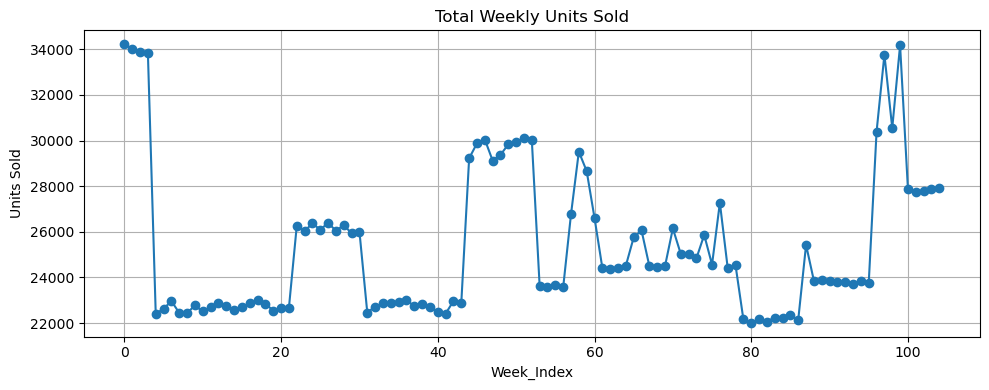

In [8]:
#Let's take a look at demand changes across the year

# Plot 1: Aggregate total units sold across all countries for each week
total_weekly_sales = beauty_eda.groupby("Week_Index")["Units_Sold"].sum().reset_index()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(total_weekly_sales["Week_Index"], total_weekly_sales["Units_Sold"], marker='o')

plt.title("Total Weekly Units Sold")
plt.xlabel("Week_Index")
plt.ylabel("Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

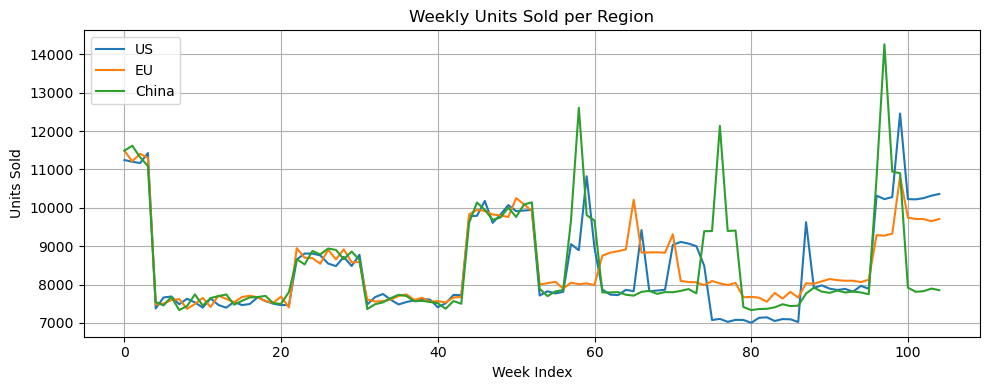

In [9]:
# Plot 2: Units Sold per Region

plt.figure(figsize=(10, 4))
for region in beauty_eda["Region"].unique():
    region_df = beauty_eda[beauty_eda["Region"] == region]
    weekly_sum = region_df.groupby("Week_Index")["Units_Sold"].sum()
    plt.plot(weekly_sum.index, weekly_sum.values, label=region)
plt.title("Weekly Units Sold per Region")
plt.xlabel("Week Index")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


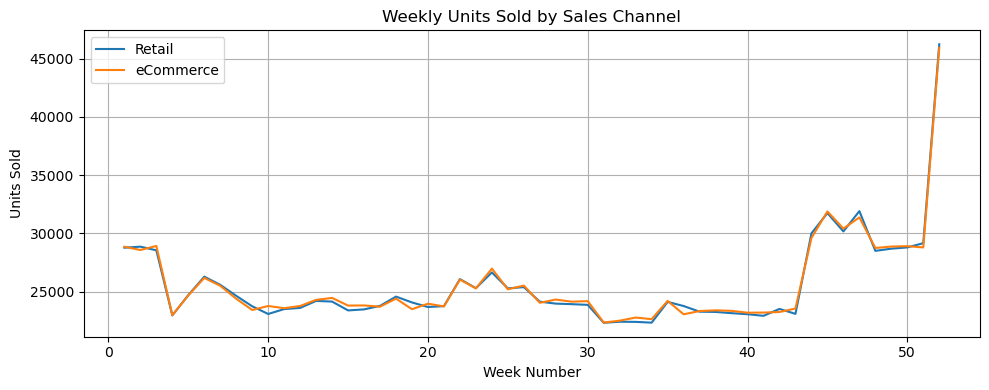

In [10]:
# Plot 3: Units Sold for Retail and eCommerce

plt.figure(figsize=(10, 4))
for channel in beauty_eda["Channel"].unique():
    ch_df = beauty_eda[beauty_eda["Channel"] == channel]
    weekly_sum = ch_df.groupby("Week_Num")["Units_Sold"].sum()
    plt.plot(weekly_sum.index, weekly_sum.values, label=channel)
plt.title("Weekly Units Sold by Sales Channel")
plt.xlabel("Week Number")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

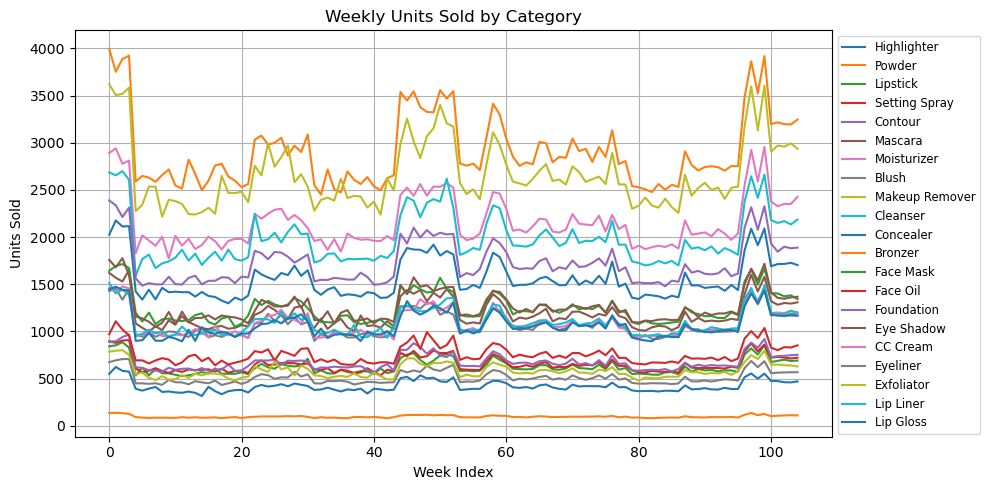

In [11]:
# Plot 4: Units Sold for Categories

plt.figure(figsize=(10, 5))
for category in beauty_eda["Category"].unique():
    cat_df = beauty_eda[beauty_eda["Category"] == category]
    weekly_sum = cat_df.groupby("Week_Index")["Units_Sold"].sum()
    plt.plot(weekly_sum.index, weekly_sum.values, label=category)
plt.title("Weekly Units Sold by Category")
plt.xlabel("Week Index")
plt.ylabel("Units Sold")
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

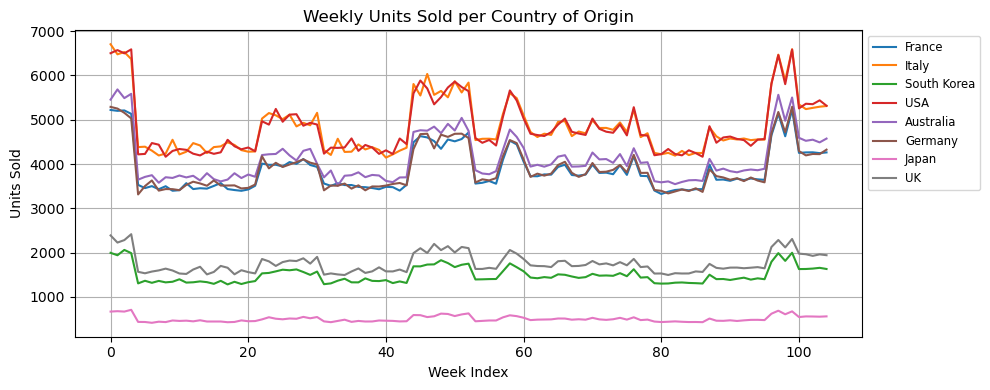

In [12]:
# Plot 5: Units Sold by Country of Origin

plt.figure(figsize=(10, 4))
for country in beauty_eda["Country_of_Origin"].unique():
    country_df = beauty_eda[beauty_eda["Country_of_Origin"] == country]
    weekly_sum = country_df.groupby("Week_Index")["Units_Sold"].sum()
    plt.plot(weekly_sum.index, weekly_sum.values, label=country)

plt.title("Weekly Units Sold per Country of Origin")
plt.xlabel("Week Index")
plt.ylabel("Units Sold")
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

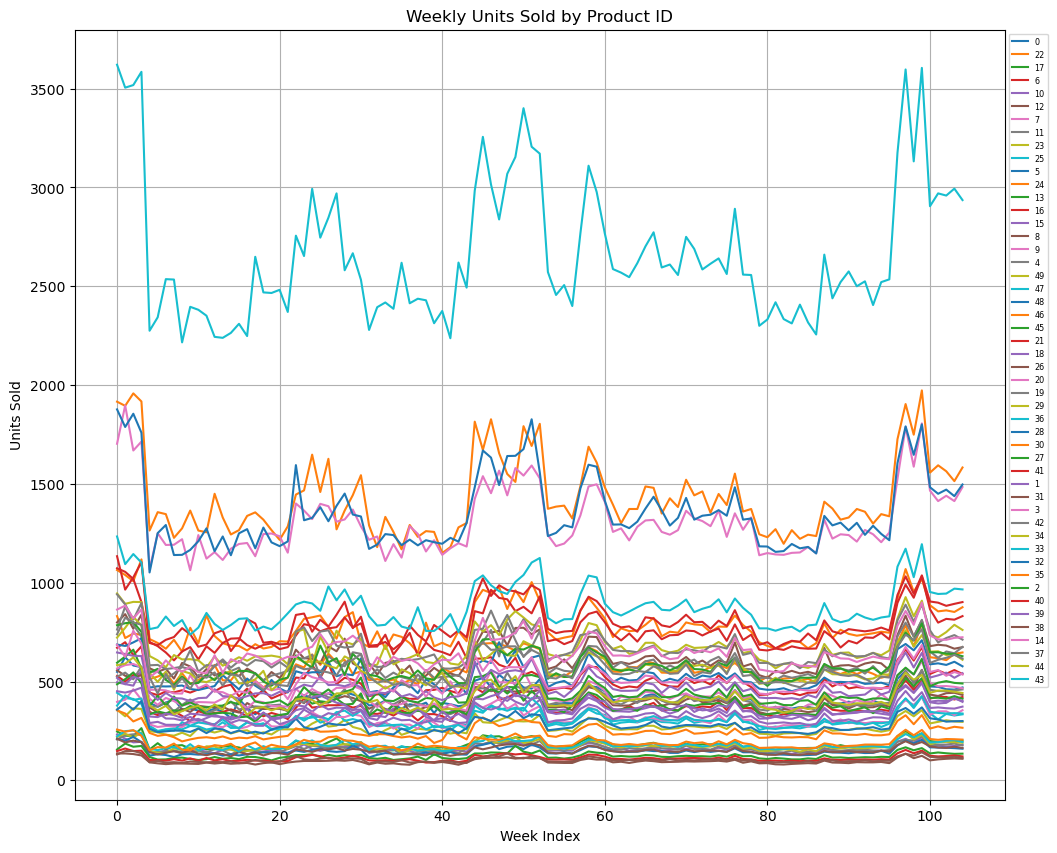

In [13]:
# Plot 6: Units Sold for Products

plt.figure(figsize=(12, 10))
colors = sns.color_palette("husl", 50)

for product in beauty_eda["Product_ID"].unique():
    prod_df = beauty_eda[beauty_eda["Product_ID"] == product]
    weekly_sum = prod_df.groupby("Week_Index")["Units_Sold"].sum()
    plt.plot(weekly_sum.index, weekly_sum.values, label=product)
 
plt.title("Weekly Units Sold by Product ID")
plt.xlabel("Week Index")
plt.ylabel("Units Sold")
plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.tight_layout()
plt.show()

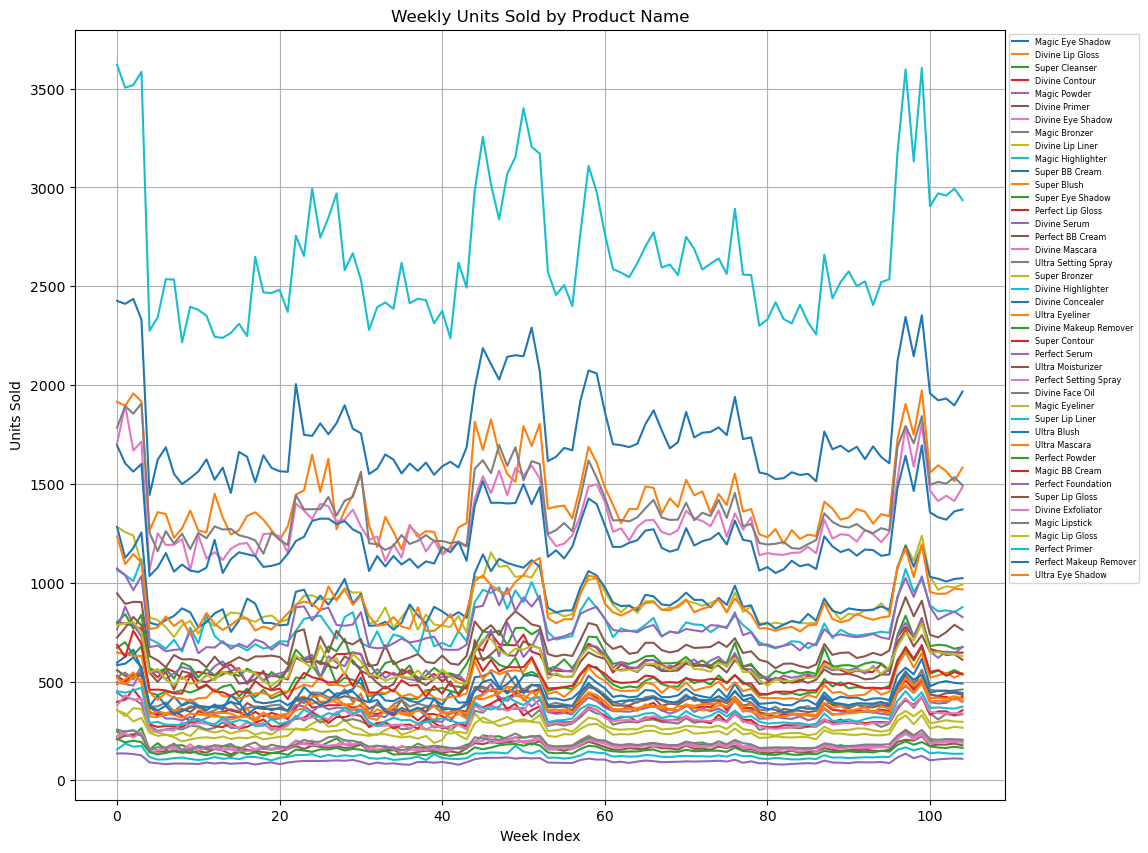

In [14]:
# Plot 7: Units Sold for Product Name

plt.figure(figsize=(12, 10))
colors = sns.color_palette("husl", 50)

for product in beauty_eda["Product_Name"].unique():
    prod_df = beauty_eda[beauty_eda["Product_Name"] == product]
    weekly_sum = prod_df.groupby("Week_Index")["Units_Sold"].sum()
    plt.plot(weekly_sum.index, weekly_sum.values, label=product)
 
plt.title("Weekly Units Sold by Product Name")
plt.xlabel("Week Index")
plt.ylabel("Units Sold")
plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.tight_layout()
plt.show()

#### Total Units Sold by Product

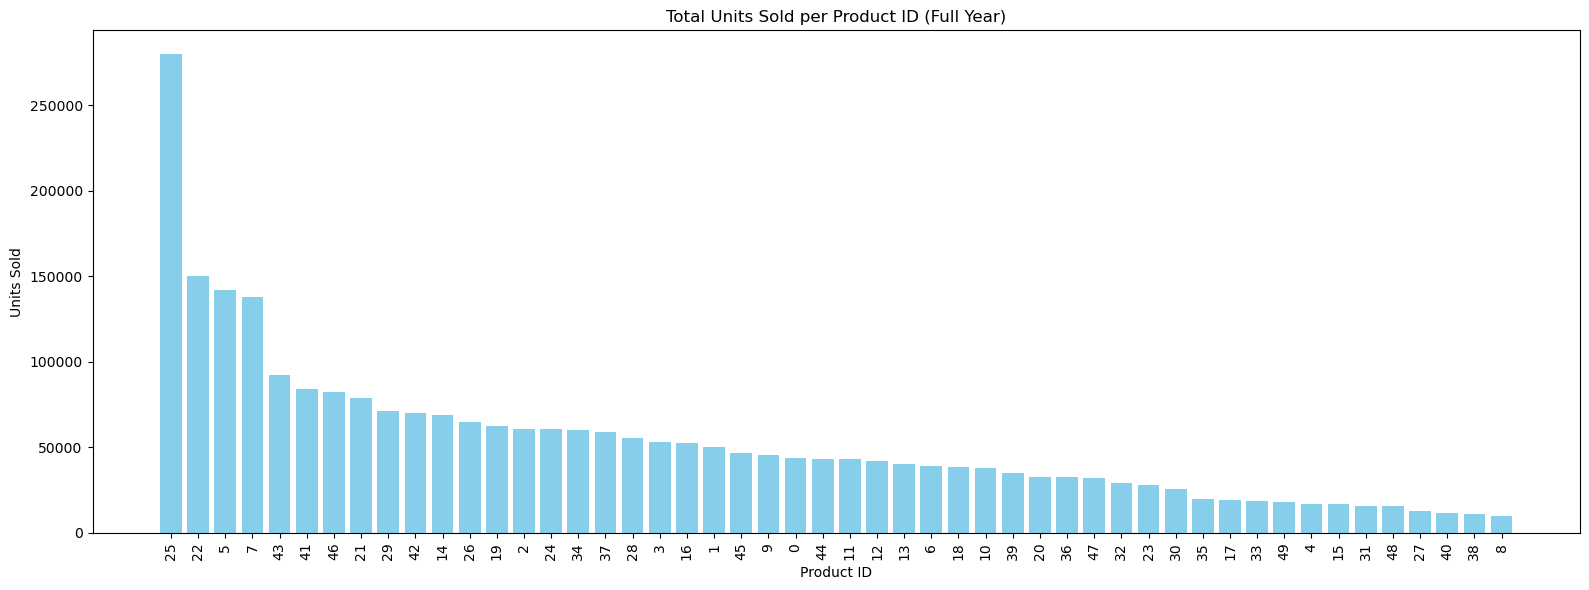

In [15]:
# Sum total units sold over the whole year for each product id

product_totals = beauty_eda.groupby("Product_ID")["Units_Sold"].sum().sort_values(ascending=False).reset_index()

# Plot as a bar chart
plt.figure(figsize=(16, 6))
plt.bar(product_totals["Product_ID"].astype(str), product_totals["Units_Sold"], color="skyblue")

plt.title("Total Units Sold per Product ID (Full Year)")
plt.xlabel("Product ID")
plt.ylabel("Units Sold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

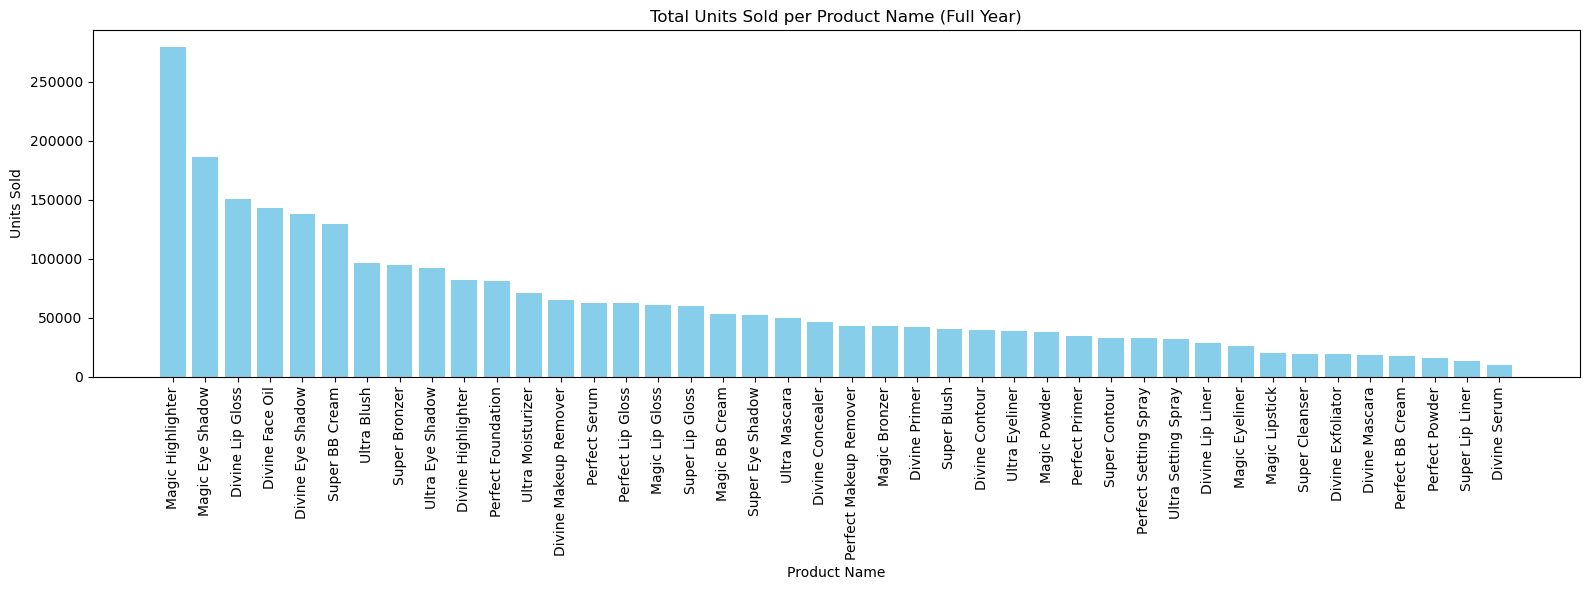

In [16]:
# Sum total units sold over the whole year for each product name

product_totals = beauty_eda.groupby("Product_Name")["Units_Sold"].sum().sort_values(ascending=False).reset_index()

# Plot as a bar chart
plt.figure(figsize=(16, 6))
plt.bar(product_totals["Product_Name"].astype(str), product_totals["Units_Sold"], color="skyblue")

plt.title("Total Units Sold per Product Name (Full Year)")
plt.xlabel("Product Name")
plt.ylabel("Units Sold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
#Checking samples

ids=[25, 22, 5, 7, 43, 14, 46, 45, 0, 23, 8]

for id in ids:
    product_df = beauty_eda[beauty_eda["Product_ID"] == id]
    print(f"Product_ID {id}: {product_df['Product_Name'].unique()[0]}")

Product_ID 25: Magic Highlighter
Product_ID 22: Divine Lip Gloss
Product_ID 5: Magic Eye Shadow
Product_ID 7: Divine Eye Shadow
Product_ID 43: Ultra Eye Shadow
Product_ID 14: Super BB Cream
Product_ID 46: Divine Highlighter
Product_ID 45: Divine Concealer
Product_ID 0: Magic Eye Shadow
Product_ID 23: Divine Lip Liner
Product_ID 8: Divine Serum


### Exploring Different Column Types

#### Identificaton of column types

In [18]:
# Identify column types

num_cols = beauty_eda.select_dtypes(include=np.number).columns.tolist()
cat_cols = beauty_eda.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = beauty_eda.select_dtypes(include='bool').columns
datetime_cols = beauty_eda.select_dtypes(include=['datetime64']).columns.tolist()
string_cols = beauty_eda.select_dtypes(include='string').columns.tolist()

print('Numeric columns:', num_cols)
print('--------')
print('Categorical columns:', cat_cols)
print('--------')
print('Boolean columns:', bool_cols.tolist())
print('--------')
print('Datetime columns:', datetime_cols)
print('--------')
print('String columns:', string_cols)

Numeric columns: ['Product_ID', 'Week_Num', 'Units_Sold', 'Promotion_Flag', 'Is_New_Launch', 'Price_USD', 'Rating', 'Week_Index']
--------
Categorical columns: ['Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Date', 'Lifecycle_Stage', 'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin']
--------
Boolean columns: ['Cruelty_Free']
--------
Datetime columns: []
--------
String columns: []


#### Numerical Columns

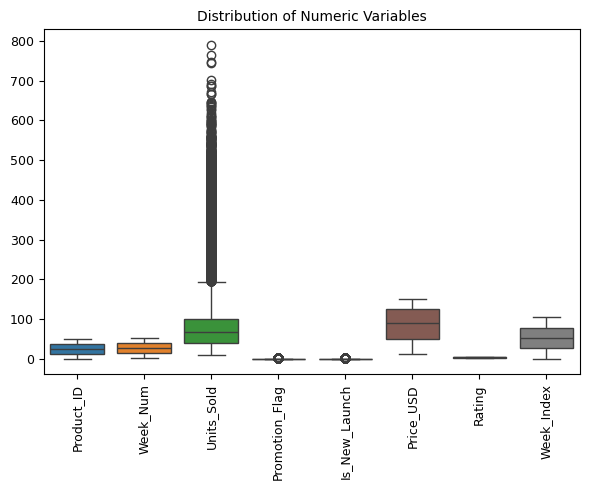

In [19]:
# Let's see the distribution of these columns

data = beauty_eda[num_cols]
fig = plt.figure(figsize=(6, 5))

sns.boxplot(data=data)
plt.xticks(fontsize=9, rotation=90)  
plt.yticks(fontsize=9) 
plt.title("Distribution of Numeric Variables", fontsize=10)  
plt.tight_layout()
plt.show()


In [20]:
# Checking outliers and their ratio

Q1 = beauty_eda[num_cols].quantile(0.25)
Q3 = beauty_eda[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = (beauty_eda[num_cols] < (Q1 - 1.5 * IQR)) | (beauty_eda[num_cols] > (Q3 + 1.5 * IQR))
outliers
outlier_num = outliers.sum()
outlier_rate = outliers.sum() / beauty_eda.shape[0]*100
outlier_df = pd.DataFrame({
    'Column Name': outlier_num.index,
    'Outlier Num': outlier_num.values,
    'Outlier Rate': outlier_rate.values,
    'Number of Unique Values': (beauty_eda[num_cols].nunique()).values
})
print(outlier_df)

      Column Name  Outlier Num  Outlier Rate  Number of Unique Values
0      Product_ID            0      0.000000                       50
1        Week_Num            0      0.000000                       52
2      Units_Sold         2249      7.139683                      570
3  Promotion_Flag         3320     10.539683                        2
4   Is_New_Launch         1200      3.809524                        2
5       Price_USD            0      0.000000                       50
6          Rating            0      0.000000                       32
7      Week_Index            0      0.000000                      105


In [21]:
# Value frequency of the binary columns

beauty_eda['Promotion_Flag'].value_counts(), beauty_eda['Is_New_Launch'].value_counts()

(Promotion_Flag
 0    28180
 1     3320
 Name: count, dtype: int64,
 Is_New_Launch
 0    30300
 1     1200
 Name: count, dtype: int64)

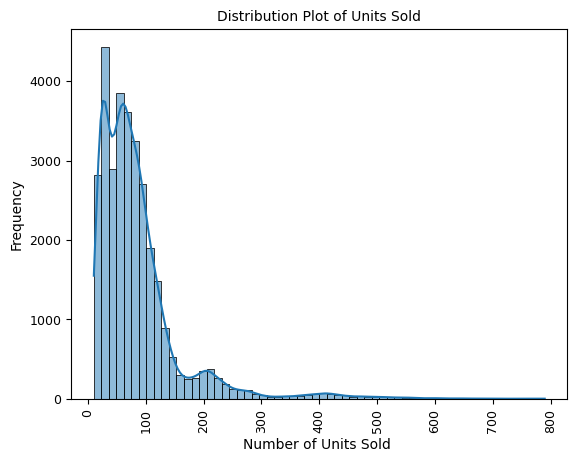

In [22]:
# Let's see the distribution of the column with outliers (Units_Sold)

data_outlier_column = beauty_eda['Units_Sold']

sns.histplot(data=data_outlier_column, bins=60, kde=True)
plt.xticks(fontsize=9, rotation=90)  # X-axis ticks font size
plt.xlabel("Number of Units Sold ")   
plt.yticks(fontsize=9)  # Y-axis ticks font size
plt.ylabel("Frequency")   
plt.title("Distribution Plot of Units Sold", fontsize=10)  # Title font size
plt.show()

In [23]:
#Checking skewness value
beauty_eda['Units_Sold'].skew()

3.0147995212078

##### Checking correlation for linear numeric features

In [24]:
#Pearson correlation

pearson_features = ["Week_Index", "Price_USD", "Rating", "Units_Sold"]
pearson_corr = beauty_eda[pearson_features].corr(method="pearson")
pearson_corr

Week_Index     Price_USD        Rating  Units_Sold
Week_Index  1.000000e+00 -1.138202e-14  4.818192e-18    0.012602
Price_USD  -1.138202e-14  1.000000e+00  3.473760e-02   -0.599775
Rating      4.818192e-18  3.473760e-02  1.000000e+00   -0.431169
Units_Sold  1.260154e-02 -5.997752e-01 -4.311688e-01    1.000000

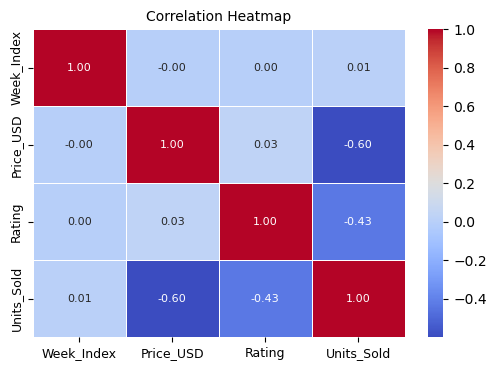

In [25]:
#With Heat Map

plt.figure(figsize=(6,4))
heat_map_num = sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})

plt.xticks(fontsize=9) 
plt.yticks(fontsize=9)  
plt.title("Correlation Heatmap", fontsize=10)  

plt.show()

#### Ordinal Columns

##### Checking correlation for ordinal features

In [97]:
#Usage Frequency

usage_frequency_values = beauty_eda["Usage_Frequency"].value_counts()
print('Usage Frequency Values:', usage_frequency_values)

usage_order = {'Occasional': 0, 'Monthly': 1, 'Weekly': 2, 'Daily': 3}
beauty_eda["Usage_Frequency_Encoded"] = beauty_eda["Usage_Frequency"].map(usage_order)

Usage Frequency Values: Usage_Frequency
Monthly       11970
Weekly         8820
Daily          5670
Occasional     5040
Name: count, dtype: int64


In [98]:
#Lifecycle Stage

lifecycle_stage_values = beauty_eda["Lifecycle_Stage"].value_counts()
print('Lifecycle Stage Values:', lifecycle_stage_values)

lifecycle_order = {'Launch': 0, 'Growth': 1, 'Mature': 2, 'Decline': 3}
beauty_eda["Lifecycle_Stage_Encoded"] = beauty_eda["Lifecycle_Stage"].map(lifecycle_order)

Lifecycle Stage Values: Lifecycle_Stage
Decline    19500
Mature      6000
Growth      4800
Launch      1200
Name: count, dtype: int64


In [99]:
#Spearman correlation

spearman_features = ["Usage_Frequency_Encoded", "Lifecycle_Stage_Encoded", "Units_Sold"]
spearman_corr = beauty_eda[spearman_features].corr(method="spearman")
spearman_corr

Usage_Frequency_Encoded  Lifecycle_Stage_Encoded  \
Usage_Frequency_Encoded                 1.000000                 0.000000   
Lifecycle_Stage_Encoded                 0.000000                 1.000000   
Units_Sold                              0.228847                 0.025735   

                         Units_Sold  
Usage_Frequency_Encoded    0.228847  
Lifecycle_Stage_Encoded    0.025735  
Units_Sold                 1.000000

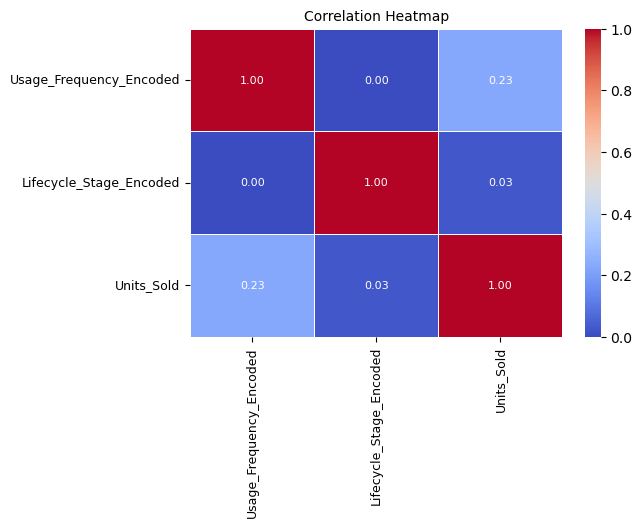

In [29]:
#With Heat Map

plt.figure(figsize=(6,4))
heat_map_ord = sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})

plt.xticks(fontsize=9) 
plt.yticks(fontsize=9)  
plt.title("Correlation Heatmap", fontsize=10)  

plt.show()

#### Binary Columns

##### Checking correlation for binary features

In [100]:
#Point-biserial correlation and Group mean comparison

binary_cols = ["Promotion_Flag", "Is_New_Launch", "Cruelty_Free"]
for col in binary_cols:
    beauty_eda[col] = beauty_eda[col].astype(int)

for col in binary_cols:
    corr, pval = pointbiserialr(beauty_eda[col], beauty_eda["Units_Sold"])
    means = beauty_eda.groupby(col)["Units_Sold"].mean()

    print(f"\n {col}")
    print(f"   * Point-Biserial Correlation: {corr:.3f} (p-value: {pval:.4f})")
    print(f"   * Group Means:\n {means}")
    print(100* '-')


 Promotion_Flag
   * Point-Biserial Correlation: 0.066 (p-value: 0.0000)
   * Group Means:
 Promotion_Flag
0    82.790774
1    98.800301
Name: Units_Sold, dtype: float64
----------------------------------------------------------------------------------------------------

 Is_New_Launch
   * Point-Biserial Correlation: 0.077 (p-value: 0.0000)
   * Group Means:
 Is_New_Launch
0     83.336733
1    113.298333
Name: Units_Sold, dtype: float64
----------------------------------------------------------------------------------------------------

 Cruelty_Free
   * Point-Biserial Correlation: -0.130 (p-value: 0.0000)
   * Group Means:
 Cruelty_Free
0    96.335317
1    76.573333
Name: Units_Sold, dtype: float64
----------------------------------------------------------------------------------------------------


Explanation:
If p < 0.0001 Its very strong evidence that the correlation is statistically significant — not due to random chance.

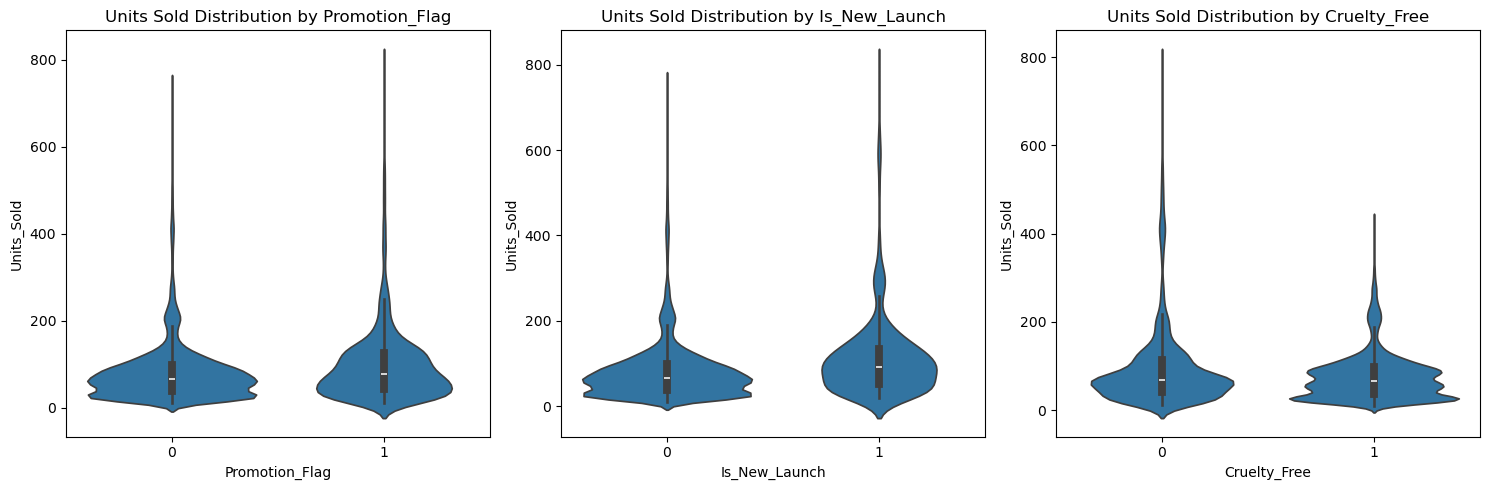

In [31]:
# Visually

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(binary_cols[:3]):
    sns.violinplot(x=col, y="Units_Sold", data=beauty_eda, inner="box", ax=axes[i])
    axes[i].set_title(f"Units Sold Distribution by {col}")

plt.tight_layout()  
plt.show()

## <span style="color:blue">3. PREPROCESSING</span>

### Creating Pseudo_SKU_ID from Product + Region + Channel

In [101]:
beauty_prep = beauty_eda.copy()

In [102]:
beauty_prep['Pseudo_SKU_ID'] = (
    beauty_prep['Product_ID'].astype(str) + "_" +
    beauty_prep['Region'].astype(str) + "_" +
    beauty_prep['Channel'].astype(str)
)

In [103]:
beauty_prep = beauty_prep[[beauty_prep.columns[-1]] + beauty_prep.columns[:-1].tolist()]

### Exploring the Segments

In [104]:
#Basic Segments
segment_stats = beauty_prep.groupby('Pseudo_SKU_ID').agg({
    'Units_Sold': ['count', 'sum', 'mean', 'std'],
    'Promotion_Flag': 'sum',
    'Is_New_Launch': 'sum'
}).reset_index()
segment_stats.columns = ['Pseudo_SKU_ID', 'Count', 'Total_Sales', 'Avg_Sales', 'Sales_STD', 'Total_Promo', 'Total_Launches']
segment_stats.head()

Pseudo_SKU_ID  Count  Total_Sales  Avg_Sales  Sales_STD  Total_Promo  \
0     0_China_Retail    105         7287  69.400000  12.918085            5   
1  0_China_eCommerce    105         7260  69.142857  13.851846            5   
2        0_EU_Retail    105         7396  70.438095  12.349808           57   
3     0_EU_eCommerce    105         7346  69.961905  10.302094            5   
4        0_US_Retail    105         7263  69.171429  12.440209            5   

   Total_Launches  
0               4  
1               4  
2               4  
3               4  
4               4

In [105]:
# Missing weeks or zero sales
zero_sales = beauty_prep.groupby('Pseudo_SKU_ID')['Units_Sold'].apply(lambda x: (x == 0).mean()).reset_index(name='Zero_Sales_Ratio')
zero_sales['Zero_Sales_Ratio'].value_counts()

Zero_Sales_Ratio
0.0    300
Name: count, dtype: int64

In [106]:
# Promotion lift effect
promo_effect = beauty_prep.groupby(['Pseudo_SKU_ID', 'Promotion_Flag'])['Units_Sold'].mean().unstack().reset_index()
promo_effect.columns = ['Pseudo_SKU_ID', 'No_Promo_Avg', 'Promo_Avg']
promo_effect['Promo_Lift'] = promo_effect['Promo_Avg'] / promo_effect['No_Promo_Avg']
promo_effect

Pseudo_SKU_ID  No_Promo_Avg  Promo_Avg  Promo_Lift
0       0_China_Retail     68.780000       81.8    1.189299
1    0_China_eCommerce     67.550000      101.0    1.495189
2          0_EU_Retail     67.395833       73.0    1.083153
3       0_EU_eCommerce     69.490000       79.4    1.142610
4          0_US_Retail     68.610000       80.4    1.171841
..                 ...           ...        ...         ...
295  9_China_eCommerce     71.230000       90.0    1.263513
296        9_EU_Retail     69.620000       88.8    1.275496
297     9_EU_eCommerce     70.970000       88.6    1.248415
298        9_US_Retail     72.540000      102.0    1.406121
299     9_US_eCommerce     72.720000      100.0    1.375138

[300 rows x 4 columns]

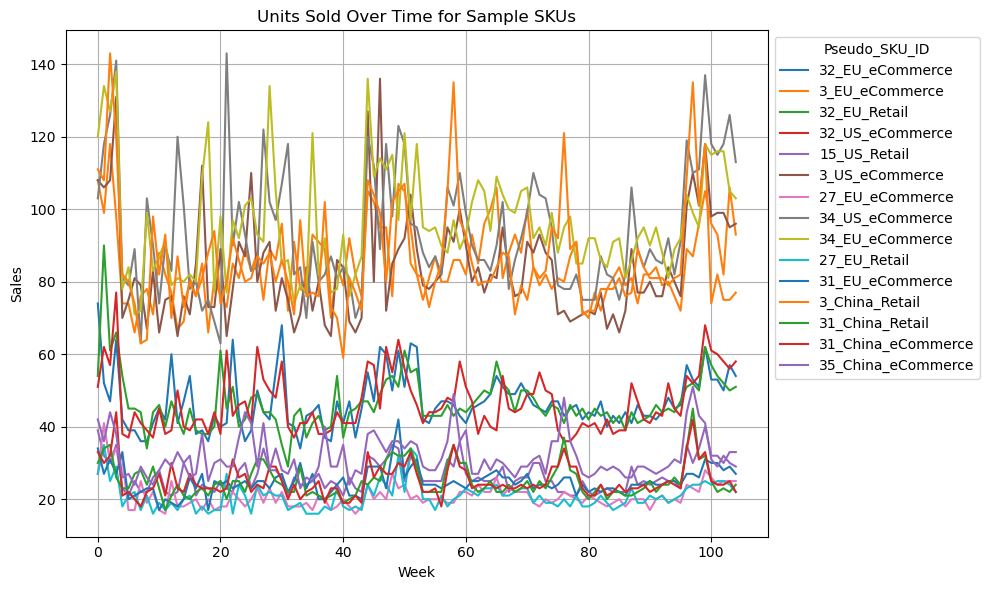

In [107]:
# Showing sample SKUs
sample_skus = beauty_prep['Pseudo_SKU_ID'].unique()[200:215]

# Create a single plot
plt.figure(figsize=(10, 6))

# Plot each SKU's sales over time
for sku in sample_skus:
    segment = beauty_prep[beauty_prep['Pseudo_SKU_ID'] == sku]
    plt.plot(segment['Week_Index'], segment['Units_Sold'], label=sku)

# Add labels and title
plt.title("Units Sold Over Time for Sample SKUs")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.grid(True)
plt.legend(title="Pseudo_SKU_ID", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Clustering

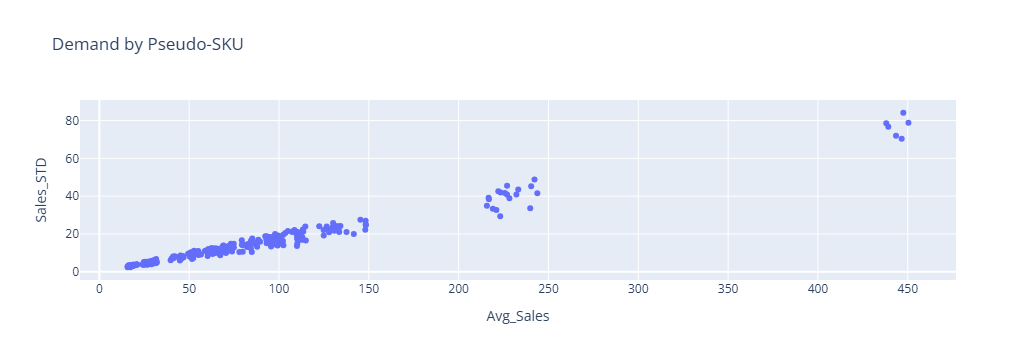

In [108]:
# Visualizing for clustering
import plotly.express as px

fig = px.scatter(
    segment_stats,
    x='Avg_Sales',
    y='Sales_STD',
    #size='Zero_Sales_Ratio',
    #color='Zero_Sales_Ratio',
    hover_name='Pseudo_SKU_ID',
    title="Demand by Pseudo-SKU"
)

fig.show()

In [109]:
# Clustering

# 1. Running KMeans on Avg_Sales and Sales_STD
clustering_data = segment_stats[['Avg_Sales', 'Sales_STD']]
kmeans = KMeans(n_clusters=4, random_state=42)
segment_stats['Demand_Cluster'] = kmeans.fit_predict(clustering_data)

# 2. Ranking clusters by Avg_Sales
cluster_avg = segment_stats.groupby("Demand_Cluster")["Avg_Sales"].mean().sort_values()
cluster_order = {old: new for new, old in enumerate(cluster_avg.index)}
segment_stats['Demand_Cluster'] = segment_stats['Demand_Cluster'].map(cluster_order)

# 3. Adding labels
cluster_labels = {
    0: "Low Demand / Stable",
    1: "Medium Demand / Stable",
    2: "High Demand / Volatile",
    3: "Very High Demand / Highly Volatile"
}
segment_stats['Demand_Label'] = segment_stats['Demand_Cluster'].map(cluster_labels)

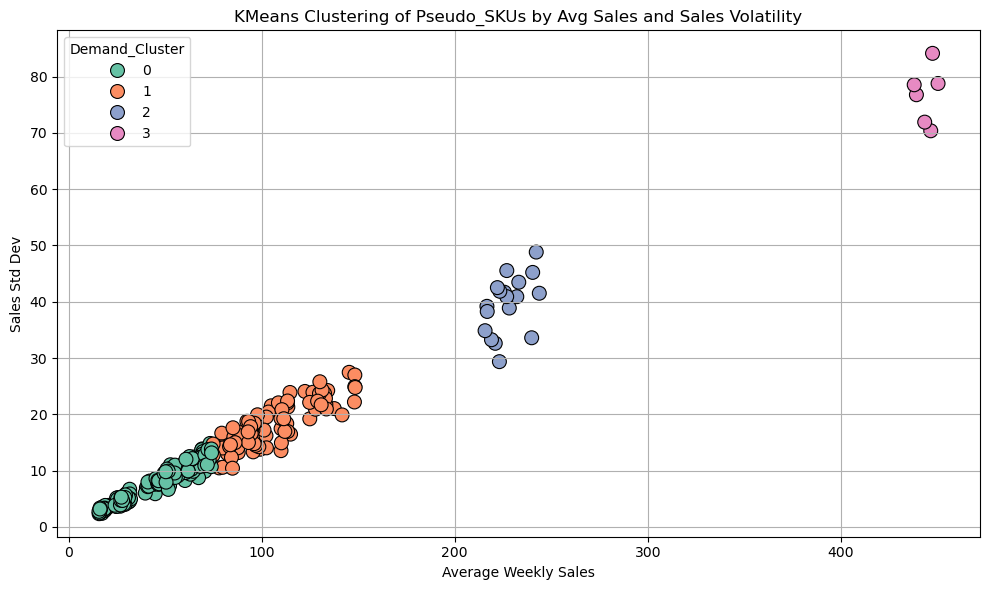

In [110]:
# Visualizing the created clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=segment_stats,
    x='Avg_Sales',
    y='Sales_STD',
    hue='Demand_Cluster',
    palette='Set2',
    s=100,
    edgecolor='black'
)
plt.title('KMeans Clustering of Pseudo_SKUs by Avg Sales and Sales Volatility')
plt.xlabel('Average Weekly Sales')
plt.ylabel('Sales Std Dev')
plt.grid(True)
plt.tight_layout()
plt.show()

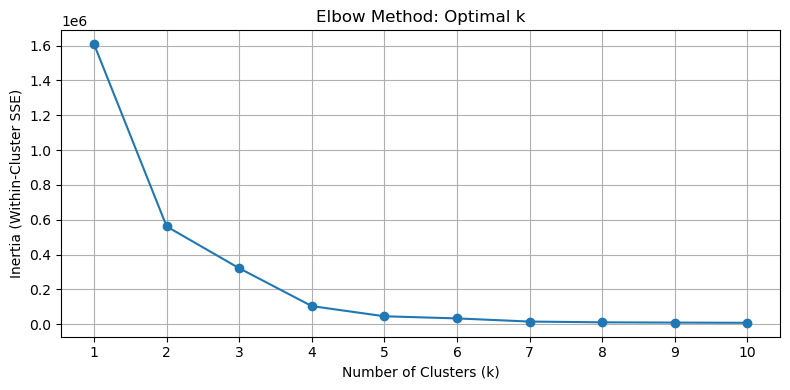

In [111]:
# Elbow Method (This shows how the within-cluster distortion (inertia) drops as k increases)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method: Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()

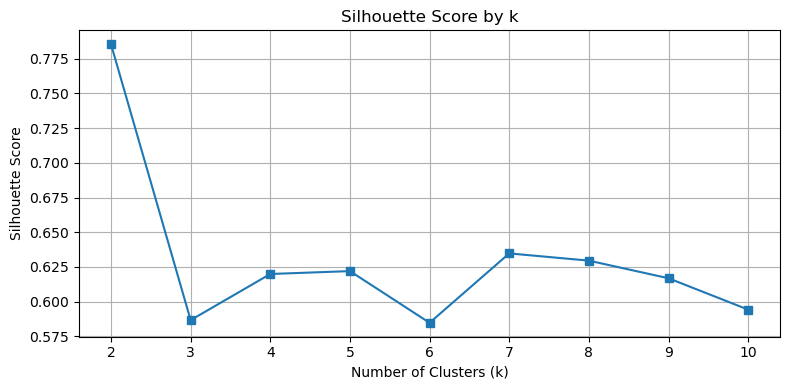

In [112]:
# Silhouette Score (Measures how well each point fits within its cluster - Peak value = best balance of cohesion and separation)
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(clustering_data)
    score = silhouette_score(clustering_data, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='s')
plt.title("Silhouette Score by k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

## <span style="color:blue">4. FEATURE ENGINEERING</span>

### Feature Engineering #1

#### Merging new features

In [113]:
# Merge promo lift into segment_stats first
segment_stats = segment_stats.merge(
    promo_effect[['Pseudo_SKU_ID', 'Promo_Lift']],
    on='Pseudo_SKU_ID',
    how='left'
)
beauty_prep = beauty_prep.merge(segment_stats[['Pseudo_SKU_ID', 'Demand_Cluster', 'Demand_Label', 'Promo_Lift']], on='Pseudo_SKU_ID', how='left')
beauty_prep.head()

Pseudo_SKU_ID  Product_ID      Product_Name            Brand  \
0      0_US_Retail           0  Magic Eye Shadow         Shiseido   
1  22_EU_eCommerce          22  Divine Lip Gloss  Kylie Cosmetics   
2  17_China_Retail          17    Super Cleanser             NARS   
3  17_EU_eCommerce          17    Super Cleanser             NARS   
4   6_EU_eCommerce           6    Divine Contour       Patrick Ta   

        Category Region    Channel      Date  Week_Num  Units_Sold  ...  \
0    Highlighter     US     Retail  1/1/2023        52         100  ...   
1         Powder     EU  eCommerce  1/1/2023        52         321  ...   
2       Lipstick  China     Retail  1/1/2023        52          41  ...   
3       Lipstick     EU  eCommerce  1/1/2023        52          42  ...   
4  Setting Spray     EU  eCommerce  1/1/2023        52          92  ...   

   Skin_Type  Gender_Target Cruelty_Free Country_of_Origin  Week_Index  \
0        Dry         Female            1            France           0   
1  Sensitive         Female            1             Italy           0   
2     Normal           Male            1       South Korea           0   
3     Normal           Male            1       South Korea           0   
4     Normal           Male            1            France           0   

   Usage_Frequency_Encoded Lifecycle_Stage_Encoded Demand_Cluster  \
0                        0                       0              0   
1                        0                       0              2   
2                        1                       0              0   
3                        1                       0              0   
4                        1                       0              0   

             Demand_Label Promo_Lift  
0     Low Demand / Stable   1.171841  
1  High Demand / Volatile   1.098474  
2     Low Demand / Stable   1.230145  
3     Low Demand / Stable   1.176471  
4     Low Demand / Stable   1.263296  

[5 rows x 26 columns]

#### Time Features

In [114]:
# Convert Date to Time Features¶
beauty_prep["Date"] = pd.to_datetime(beauty_eda["Date"])
beauty_prep["Month"] = beauty_prep["Date"].dt.month
beauty_prep["Quarter"] = beauty_prep["Date"].dt.quarter

print(beauty_prep["Date"].dtype)
print(beauty_prep["Month"].dtype)
print(beauty_prep["Quarter"].dtype)

datetime64[ns]
int32
int32


#### Past demand snapshots (Produts sold in 1, 2, 4 weeks ago) 

In [115]:
#Lag_1w, Lag_2w, Lag_4w 

# Sort to ensure proper lag alignment
beauty_prep = beauty_prep.sort_values(["Pseudo_SKU_ID", "Date"])

# Create lag features
lags = [1, 2, 4]
for lag in lags:
    beauty_prep[f"Lag_{lag}w"] = beauty_prep.groupby("Pseudo_SKU_ID")["Units_Sold"].shift(lag)

# Optional: reset index for cleanliness
beauty_prep = beauty_prep.reset_index(drop=True)

# View results
print(beauty_prep[["Pseudo_SKU_ID", "Date", "Units_Sold", "Lag_1w", "Lag_2w", "Lag_4w"]].head(5))

    Pseudo_SKU_ID       Date  Units_Sold  Lag_1w  Lag_2w  Lag_4w
0  0_China_Retail 2023-01-01          99     NaN     NaN     NaN
1  0_China_Retail 2023-01-08          93    99.0     NaN     NaN
2  0_China_Retail 2023-01-15          86    93.0    99.0     NaN
3  0_China_Retail 2023-01-22          99    86.0    93.0     NaN
4  0_China_Retail 2023-01-29          64    99.0    86.0    99.0


#### Local trend & stability (Average demand and standard deviation over past 4-weeks)

In [116]:
#RollingMean_4w , RollingStd_4w 

# Sort to ensure correct lag
beauty_prep = beauty_prep.sort_values(["Pseudo_SKU_ID", "Date"])

# Compute rolling features for window size of 4
beauty_prep["RollingMean_4w"] = (
    beauty_prep.groupby("Pseudo_SKU_ID")["Units_Sold"]
    .shift(1)
    .rolling(window=4)
    .mean()
)

beauty_prep["RollingStd_4w"] = (
    beauty_prep.groupby("Pseudo_SKU_ID")["Units_Sold"]
    .shift(1)
    .rolling(window=4)
    .std()
)

# Check results
print(beauty_prep[["Pseudo_SKU_ID", "Date", "Units_Sold", "RollingMean_4w", "RollingStd_4w"]].head(8))

    Pseudo_SKU_ID       Date  Units_Sold  RollingMean_4w  RollingStd_4w
0  0_China_Retail 2023-01-01          99             NaN            NaN
1  0_China_Retail 2023-01-08          93             NaN            NaN
2  0_China_Retail 2023-01-15          86             NaN            NaN
3  0_China_Retail 2023-01-22          99             NaN            NaN
4  0_China_Retail 2023-01-29          64           94.25       6.184658
5  0_China_Retail 2023-02-05          68           85.50      15.286159
6  0_China_Retail 2023-02-12          59           79.25      16.276261
7  0_China_Retail 2023-02-19          72           72.50      18.046237


#### Recent change in demand

In [117]:
#Lag_Diff_1w 

beauty_prep["Lag_Diff_1w"] = beauty_prep["Lag_1w"] - beauty_prep["Lag_2w"]
print(beauty_prep[["Pseudo_SKU_ID", "Date", "Units_Sold", "Lag_1w", "Lag_2w", "Lag_Diff_1w"]].head(8))

    Pseudo_SKU_ID       Date  Units_Sold  Lag_1w  Lag_2w  Lag_Diff_1w
0  0_China_Retail 2023-01-01          99     NaN     NaN          NaN
1  0_China_Retail 2023-01-08          93    99.0     NaN          NaN
2  0_China_Retail 2023-01-15          86    93.0    99.0         -6.0
3  0_China_Retail 2023-01-22          99    86.0    93.0         -7.0
4  0_China_Retail 2023-01-29          64    99.0    86.0         13.0
5  0_China_Retail 2023-02-05          68    64.0    99.0        -35.0
6  0_China_Retail 2023-02-12          59    68.0    64.0          4.0
7  0_China_Retail 2023-02-19          72    59.0    68.0         -9.0


#### Impact of discount on demand

In [118]:
#Price_Promo_Interaction
beauty_prep["Price_Promo_Interaction"] =beauty_prep["Price_USD"] *beauty_prep["Promotion_Flag"]
print(beauty_prep[["Pseudo_SKU_ID", "Price_USD", "Promotion_Flag", "Price_Promo_Interaction"]].head(8))

    Pseudo_SKU_ID  Price_USD  Promotion_Flag  Price_Promo_Interaction
0  0_China_Retail      45.92               0                     0.00
1  0_China_Retail      45.92               0                     0.00
2  0_China_Retail      45.92               0                     0.00
3  0_China_Retail      45.92               0                     0.00
4  0_China_Retail      45.92               0                     0.00
5  0_China_Retail      45.92               0                     0.00
6  0_China_Retail      45.92               1                    45.92
7  0_China_Retail      45.92               0                     0.00


#### Capturing Seasonal Lift

In [119]:
#Is_Holiday_Season

beauty_prep = beauty_prep.sort_values(["Pseudo_SKU_ID", "Date"])

beauty_prep["Is_Holiday_Season"] = beauty_prep["Month"].apply(lambda x: 1 if x in [11, 12] else 0)
print(beauty_prep[["Pseudo_SKU_ID", "Is_Holiday_Season"]].head(8))

    Pseudo_SKU_ID  Is_Holiday_Season
0  0_China_Retail                  0
1  0_China_Retail                  0
2  0_China_Retail                  0
3  0_China_Retail                  0
4  0_China_Retail                  0
5  0_China_Retail                  0
6  0_China_Retail                  0
7  0_China_Retail                  0


In [120]:
#Is_MidYear_Lift

beauty_prep = beauty_prep.sort_values(["Product_ID", "Date"])

beauty_prep["Is_MidYear_Lift"] = beauty_prep["Week_Index"].apply(lambda x: 1 if 22 <= x <= 31 else 0)
print(beauty_prep[["Pseudo_SKU_ID", "Is_MidYear_Lift"]].head(8))

         Pseudo_SKU_ID  Is_MidYear_Lift
0       0_China_Retail                0
105  0_China_eCommerce                0
210        0_EU_Retail                0
315     0_EU_eCommerce                0
420        0_US_Retail                0
525     0_US_eCommerce                0
1       0_China_Retail                0
106  0_China_eCommerce                0


#### Product age effect

In [121]:
#Time_Since_Launch

# Ensure Date is datetime
beauty_prep["Date"] = pd.to_datetime(beauty_prep["Date"])

# Computing time (in days) since the first sale (launch) for each product
beauty_prep["Time_Since_Launch"] = beauty_prep.groupby("Pseudo_SKU_ID")["Date"].transform(lambda x: (x - x.min()).dt.days)

print(beauty_prep[["Pseudo_SKU_ID", "Time_Since_Launch"]].head(8))

         Pseudo_SKU_ID  Time_Since_Launch
0       0_China_Retail                  0
105  0_China_eCommerce                  0
210        0_EU_Retail                  0
315     0_EU_eCommerce                  0
420        0_US_Retail                  0
525     0_US_eCommerce                  0
1       0_China_Retail                  7
106  0_China_eCommerce                  7


### Splitting the dataset

In [122]:
#Let's split the data into train and test sets with a time-based split

# Sorting first
beauty_prep = beauty_prep.sort_values("Date")

# Define cutoff date (e.g., last 12 weeks for test)
cutoff = beauty_prep["Date"].max() - pd.Timedelta(weeks=12)

# Split
train = beauty_prep[beauty_prep["Date"] <= cutoff].copy()
test =beauty_prep[beauty_prep["Date"] > cutoff].copy()

print(train.shape)
print(test.shape)

(27900, 38)
(3600, 38)


In [123]:
print(train["Date"].min(), train["Date"].max())
print(test["Date"].min(), test["Date"].max())

2023-01-01 00:00:00 2024-10-06 00:00:00
2024-10-13 00:00:00 2024-12-29 00:00:00


### Feature Engineering #2

#### Context-level benchmark

In [124]:
#Avg_Demand_By_Category/Brand

# Sorting first
train = train.sort_values("Date")
test = test.sort_values("Date")

train["Avg_Demand_By_Category"] = train.groupby("Category")["Units_Sold"].transform("mean")
train["Avg_Demand_By_Brand"] = train.groupby("Brand")["Units_Sold"].transform("mean")

test["Avg_Demand_By_Category"] = test.groupby("Category")["Units_Sold"].transform("mean")
test["Avg_Demand_By_Brand"] = test.groupby("Brand")["Units_Sold"].transform("mean")

print(train[["Month", "Avg_Demand_By_Category"]].head(2))
print(test[["Month", "Avg_Demand_By_Category"]].head(2))                

print(train[["Month", "Avg_Demand_By_Brand"]].head(2))
print(test[["Month", "Avg_Demand_By_Brand"]].head(2))    

      Month  Avg_Demand_By_Category
0         1               68.722222
6090      1               59.386499
       Month  Avg_Demand_By_Category
1353      10               66.444444
30228     10              133.768519
      Month  Avg_Demand_By_Brand
0         1            57.147551
6090      1            57.184140
       Month  Avg_Demand_By_Brand
1353      10            76.750000
30228     10           153.268519


#### Ranking products within each Category and Brand

In [125]:
#Units_Sold_Rank_Per_Product

train["Units_Sold_Rank_Per_Product_Cat"] = (train.groupby(["Category", "Month"])["Units_Sold"].rank(ascending=False, method="min"))
test["Units_Sold_Rank_Per_Product_Cat"] = (test.groupby(["Category", "Month"])["Units_Sold"].rank(ascending=False, method="min"))

train["Units_Sold_Rank_Per_Product_Brand"] = (train.groupby(["Brand", "Month"])["Units_Sold"].rank(ascending=False, method="min"))
test["Units_Sold_Rank_Per_Product_Brand"] = (test.groupby(["Brand", "Month"])["Units_Sold"].rank(ascending=False, method="min"))

print(train[["Category", "Month", "Units_Sold_Rank_Per_Product_Cat"]].head(2))
print(5*"-----")
print(test[["Category", "Month", "Units_Sold_Rank_Per_Product_Cat"]].head(2))
print(5*"-----")
print(train[["Brand", "Month", "Units_Sold_Rank_Per_Product_Brand"]].head(2))
print(5*"-----")
print(test[["Brand", "Month", "Units_Sold_Rank_Per_Product_Brand"]].head(2))

         Category  Month  Units_Sold_Rank_Per_Product_Cat
0     Highlighter      1                              8.0
6090     CC Cream      1                             68.0
-------------------------
          Category  Month  Units_Sold_Rank_Per_Product_Cat
1353         Blush     10                             23.0
30228  Moisturizer     10                              7.0
-------------------------
         Brand  Month  Units_Sold_Rank_Per_Product_Brand
0     Shiseido      1                               25.0
6090   Kiehl’s      1                               74.0
-------------------------
             Brand  Month  Units_Sold_Rank_Per_Product_Brand
1353      Glossier     10                                5.0
30228  Bite Beauty     10                                7.0


### Handling New Missing Values

In [126]:
#Checking for Naans

# For train set
print("Train NaN counts:\n", train.isnull().sum()[train.isnull().sum() > 0])

# For test set
print("Test NaN counts:\n", test.isnull().sum()[test.isnull().sum() > 0])

Train NaN counts:
 Lag_1w             300
Lag_2w             600
Lag_4w            1200
RollingMean_4w    1200
RollingStd_4w     1200
Lag_Diff_1w        600
dtype: int64
Test NaN counts:
 Series([], dtype: int64)


In [127]:
#Handling remaining NaaNs

# Make sure both are sorted for time-based operations
train = train.sort_values(["Pseudo_SKU_ID", "Date"]).copy()
test = test.sort_values(["Pseudo_SKU_ID", "Date"]).copy()

# --- Rolling features with min_periods=1 ---
for df in [train, test]:
    df["RollingMean_4w"] = df.groupby("Pseudo_SKU_ID")["Units_Sold"].transform(
        lambda x: x.rolling(window=4, min_periods=1).mean()
    )
    df["RollingStd_4w"] = df.groupby("Pseudo_SKU_ID")["Units_Sold"].transform(
        lambda x: x.rolling(window=4, min_periods=1).std()
    )

# --- Fill remaining NaNs in RollingStd (1 per group max) ---
for df in [train, test]:
    df["RollingStd_4w"] = df.groupby("Pseudo_SKU_ID")["RollingStd_4w"].transform(
        lambda x: x.fillna(x.median())
    )

# --- Fill lag feature NaNs with median per SKU ---
lag_cols = ["Lag_1w", "Lag_2w", "Lag_4w", "Lag_Diff_1w", "RollingMean_4w", "RollingStd_4w"]

for col in lag_cols:
    train[col] = train.groupby("Pseudo_SKU_ID")[col].transform(lambda x: x.fillna(x.median()))
    test[col] = test.groupby("Pseudo_SKU_ID")[col].transform(lambda x: x.fillna(x.median()))

# --- Final sanity check ---
print("Train NaNs:\n", train[lag_cols].isnull().sum())
print("Test NaNs:\n", test[lag_cols].isnull().sum())

Train NaNs:
 Lag_1w            0
Lag_2w            0
Lag_4w            0
Lag_Diff_1w       0
RollingMean_4w    0
RollingStd_4w     0
dtype: int64
Test NaNs:
 Lag_1w            0
Lag_2w            0
Lag_4w            0
Lag_Diff_1w       0
RollingMean_4w    0
RollingStd_4w     0
dtype: int64


In [128]:
#Checking for Naans

# For train set
print("Train NaN counts:\n", train.isnull().sum()[train.isnull().sum() > 0])

# For test set
print("Test NaN counts:\n", test.isnull().sum()[test.isnull().sum() > 0])

Train NaN counts:
 Series([], dtype: int64)
Test NaN counts:
 Series([], dtype: int64)


In [129]:
# Final sanity check
assert train.isnull().sum().sum() == 0, "Train still contains NaNs!"
assert test.isnull().sum().sum() == 0, "Test still contains NaNs!"

In [130]:
print(train.shape, test.shape)

(27900, 42) (3600, 42)


In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27900 entries, 0 to 31487
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Pseudo_SKU_ID                      27900 non-null  object        
 1   Product_ID                         27900 non-null  int64         
 2   Product_Name                       27900 non-null  object        
 3   Brand                              27900 non-null  object        
 4   Category                           27900 non-null  object        
 5   Region                             27900 non-null  object        
 6   Channel                            27900 non-null  object        
 7   Date                               27900 non-null  datetime64[ns]
 8   Week_Num                           27900 non-null  int64         
 9   Units_Sold                         27900 non-null  int64         
 10  Promotion_Flag                     2790

#### Saving Raw Data

In [132]:
# Saving raw data
train_featured = train.copy()
test_featured = test.copy()

# Sorting by Date and ID
train_featured = train_featured.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)
test_featured  = test_featured.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)

# train_featured.to_parquet("../data/train_featured_raw.parquet")
# test_featured.to_parquet("../data/test_featured_raw.parquet")

### Handling Skewness

In [133]:
#Applying Log Transform

train_featured['Units_Sold_Log'] = np.log1p(train_featured['Units_Sold'])
test_featured['Units_Sold_Log'] = np.log1p(test_featured['Units_Sold'])

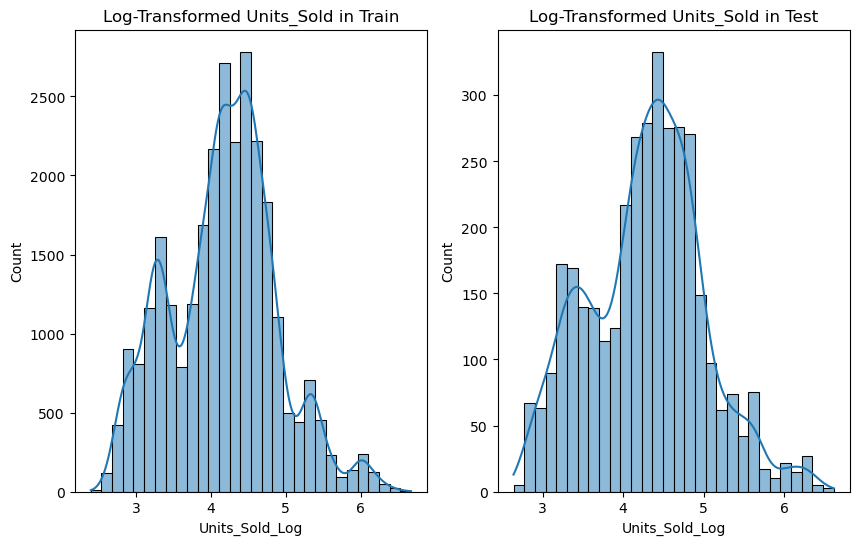

In [134]:
#Visualizing Results

fig, axes = plt.subplots(1, 2, figsize=(10,6))

sns.histplot(train_featured['Units_Sold_Log'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Log-Transformed Units_Sold in Train")


sns.histplot(test_featured['Units_Sold_Log'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Units_Sold in Test")
plt.show()

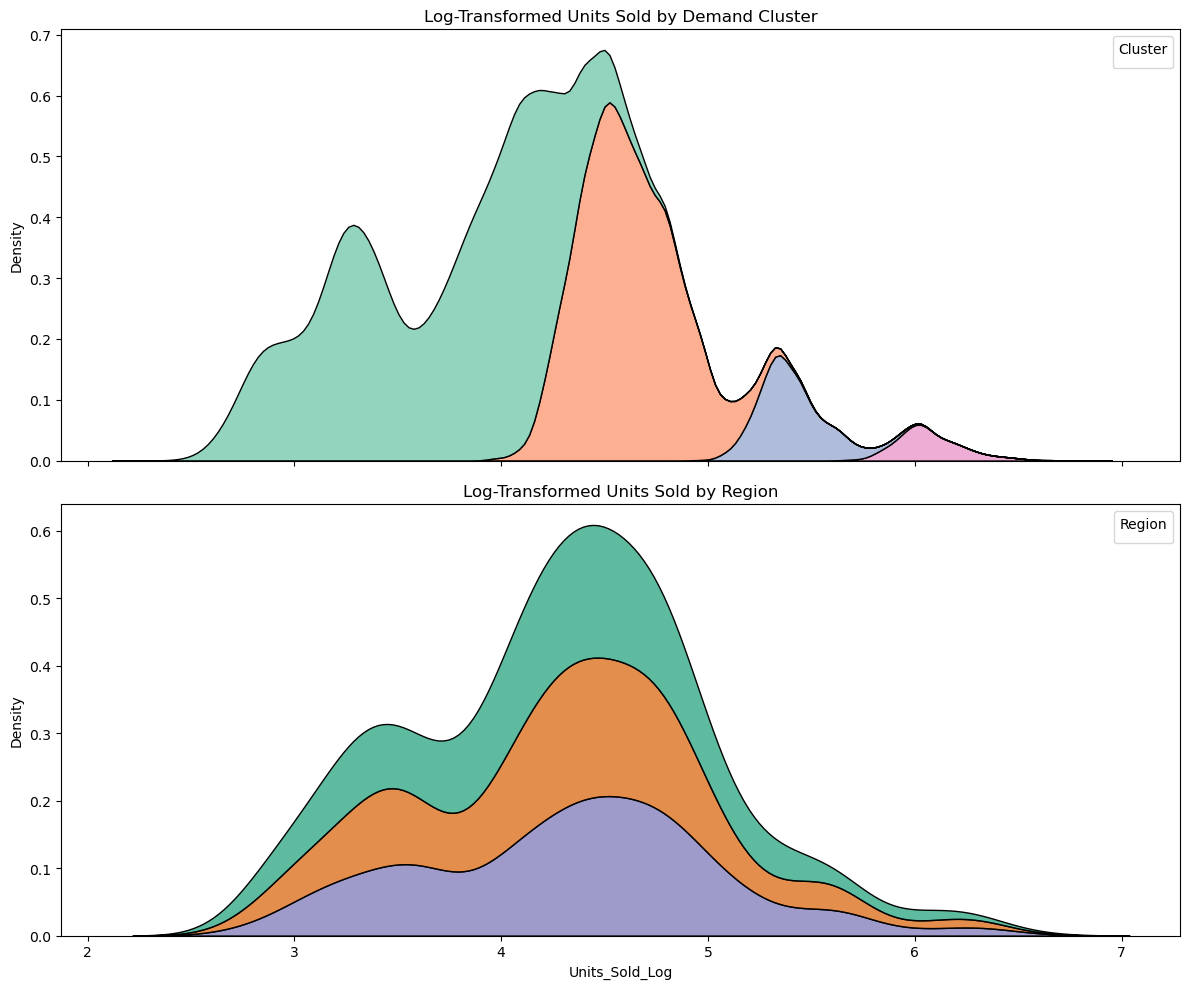

In [135]:
# Plot distribution by Demand Cluster and Region
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.kdeplot(
    data=train_featured,
    x="Units_Sold_Log",
    hue="Demand_Cluster",
    multiple="stack",
    palette="Set2",
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Log-Transformed Units Sold by Demand Cluster")
axes[0].legend(title="Cluster")

sns.kdeplot(
    data=test_featured,
    x="Units_Sold_Log",
    hue="Region",
    multiple="stack",
    palette="Dark2",
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("Log-Transformed Units Sold by Region")
axes[1].legend(title="Region")

plt.tight_layout()
plt.show()

In [136]:
print(train_featured["Week_Index"].min(), train_featured["Week_Index"].max())
print(test_featured["Week_Index"].min(), test_featured["Week_Index"].max())

0 92
93 104


## <span style="color:blue">5. DATA CLEANUP</span>

### Checking Rare Categories to Reduce

In [137]:
# Identifying categorical column types again
cat_cols = train_featured.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical columns:', cat_cols)

Categorical columns: ['Pseudo_SKU_ID', 'Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage', 'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']


In [138]:
#Finding the columns with many unique values
train_featured.nunique()

Pseudo_SKU_ID                          300
Product_ID                              50
Product_Name                            42
Brand                                   30
Category                                21
Region                                   3
Channel                                  2
Date                                    93
Week_Num                                52
Units_Sold                             545
Promotion_Flag                           2
Is_New_Launch                            2
Lifecycle_Stage                          4
Usage_Frequency                          4
Price_USD                               50
Rating                                  32
Skin_Type                                5
Gender_Target                            3
Cruelty_Free                             2
Country_of_Origin                        8
Week_Index                              93
Usage_Frequency_Encoded                  4
Lifecycle_Stage_Encoded                  4
Demand_Clus

In [139]:
#Calculating proportions for Product_Name (42 unique), Brand (30 unique) and Category (21 unique) 

pname_dist = train_featured["Product_Name"].value_counts(normalize=True) * 100
brand_dist = train_featured["Brand"].value_counts(normalize=True) * 100
category_dist = train_featured["Category"].value_counts(normalize=True) * 100

print(pname_dist)
print(brand_dist)
print(category_dist)

Product_Name
Divine Face Oil           6.0
Magic Eye Shadow          4.0
Super Bronzer             4.0
Super BB Cream            4.0
Perfect Lip Gloss         4.0
Perfect Foundation        4.0
Ultra Blush               4.0
Super Lip Gloss           2.0
Magic Lipstick            2.0
Perfect Setting Spray     2.0
Perfect Primer            2.0
Magic BB Cream            2.0
Perfect Makeup Remover    2.0
Ultra Eye Shadow          2.0
Perfect Powder            2.0
Divine Concealer          2.0
Divine Highlighter        2.0
Ultra Setting Spray       2.0
Divine Mascara            2.0
Perfect BB Cream          2.0
Divine Contour            2.0
Divine Eye Shadow         2.0
Divine Exfoliator         2.0
Magic Lip Gloss           2.0
Magic Eyeliner            2.0
Magic Powder              2.0
Magic Bronzer             2.0
Divine Primer             2.0
Super Blush               2.0
Super Eye Shadow          2.0
Super Cleanser            2.0
Ultra Eyeliner            2.0
Perfect Serum             2

*No values are under the 2% threshold - we are keeping them all.*

#### Saving Start Data

In [140]:
# Saving start data
train_start = train_featured.copy()
test_start = test_featured.copy()

# Sorting by Date and ID
train_start = train_start.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)
test_start  = test_start.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)

# train_start.to_parquet("../data/train_featured_start.parquet")
# test_start.to_parquet("../data/test_featured_start.parquet")

In [141]:
print("Train shape:", train_start.shape)
print("Test shape:", test_start.shape)

Train shape: (27900, 43)
Test shape: (3600, 43)


In [142]:
train_start.nunique()

Pseudo_SKU_ID                          300
Product_ID                              50
Product_Name                            42
Brand                                   30
Category                                21
Region                                   3
Channel                                  2
Date                                    93
Week_Num                                52
Units_Sold                             545
Promotion_Flag                           2
Is_New_Launch                            2
Lifecycle_Stage                          4
Usage_Frequency                          4
Price_USD                               50
Rating                                  32
Skin_Type                                5
Gender_Target                            3
Cruelty_Free                             2
Country_of_Origin                        8
Week_Index                              93
Usage_Frequency_Encoded                  4
Lifecycle_Stage_Encoded                  4
Demand_Clus

### Column check

In [143]:
# Identify column types of TRAIN set

num_cols = train_start.select_dtypes(include=np.number).columns.tolist()
cat_cols = train_start.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = train_start.select_dtypes(include='bool').columns
datetime_cols = train_start.select_dtypes(include=['datetime64']).columns.tolist()
string_cols = train_start.select_dtypes(include='string').columns.tolist()

print('Numeric columns:', num_cols)
print('--------')
print('Categorical columns:', cat_cols)
print('--------')
print('Boolean columns:', bool_cols.tolist())
print('--------')
print('Datetime columns:', datetime_cols)
print('--------')
print('String columns:', string_cols)

Numeric columns: ['Product_ID', 'Week_Num', 'Units_Sold', 'Promotion_Flag', 'Is_New_Launch', 'Price_USD', 'Rating', 'Cruelty_Free', 'Week_Index', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded', 'Demand_Cluster', 'Promo_Lift', 'Month', 'Quarter', 'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w', 'Price_Promo_Interaction', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Time_Since_Launch', 'Avg_Demand_By_Category', 'Avg_Demand_By_Brand', 'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand', 'Units_Sold_Log']
--------
Categorical columns: ['Pseudo_SKU_ID', 'Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage', 'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']
--------
Boolean columns: []
--------
Datetime columns: ['Date']
--------
String columns: []


In [144]:
# Identify column types of TEST set

num_cols = test_start.select_dtypes(include=np.number).columns.tolist()
cat_cols = test_start.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = test_start.select_dtypes(include='bool').columns
datetime_cols = test_start.select_dtypes(include=['datetime64']).columns.tolist()
string_cols = test_start.select_dtypes(include='string').columns.tolist()

print('Numeric columns:', num_cols)
print('--------')
print('Categorical columns:', cat_cols)
print('--------')
print('Boolean columns:', bool_cols.tolist())
print('--------')
print('Datetime columns:', datetime_cols)
print('--------')
print('String columns:', string_cols)

Numeric columns: ['Product_ID', 'Week_Num', 'Units_Sold', 'Promotion_Flag', 'Is_New_Launch', 'Price_USD', 'Rating', 'Cruelty_Free', 'Week_Index', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded', 'Demand_Cluster', 'Promo_Lift', 'Month', 'Quarter', 'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w', 'Price_Promo_Interaction', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Time_Since_Launch', 'Avg_Demand_By_Category', 'Avg_Demand_By_Brand', 'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand', 'Units_Sold_Log']
--------
Categorical columns: ['Pseudo_SKU_ID', 'Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage', 'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']
--------
Boolean columns: []
--------
Datetime columns: ['Date']
--------
String columns: []


In [145]:
print(train_start.shape)
print(test_start.shape)

(27900, 43)
(3600, 43)


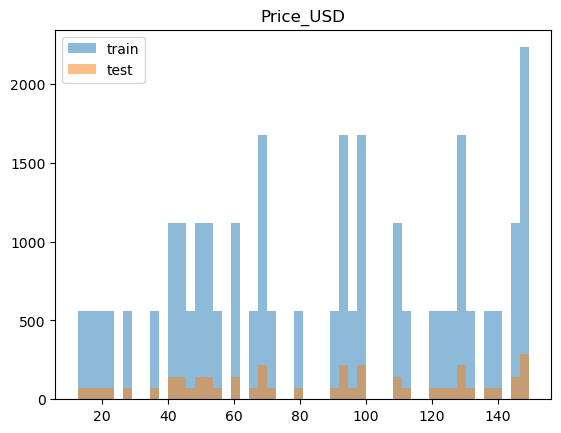

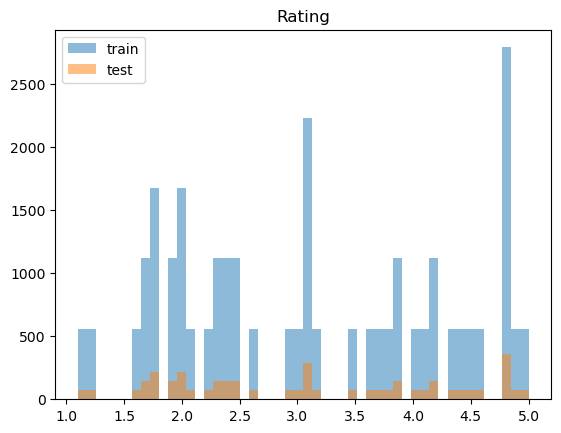

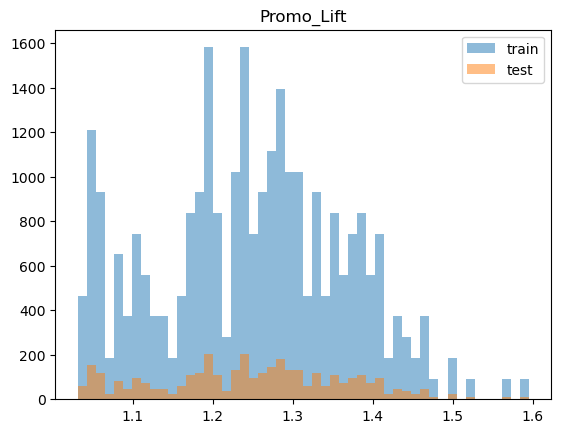

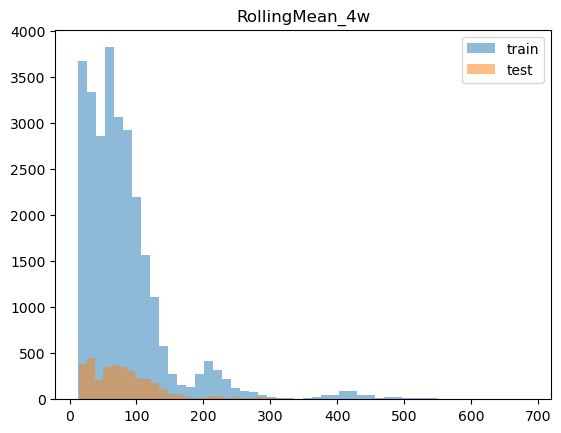

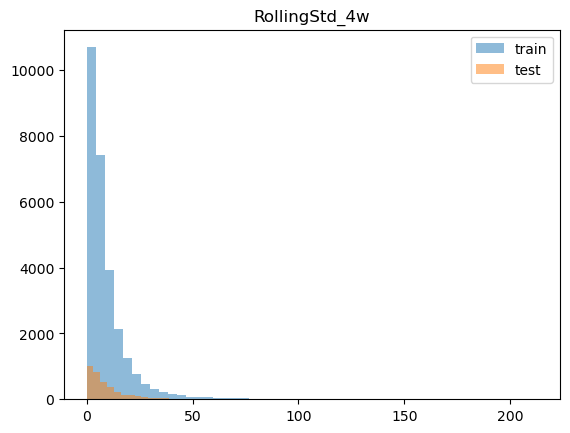

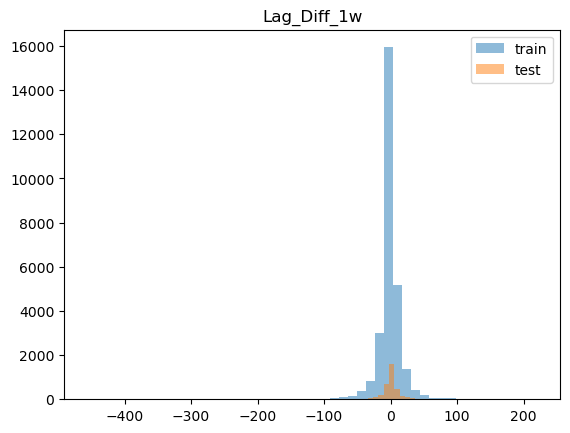

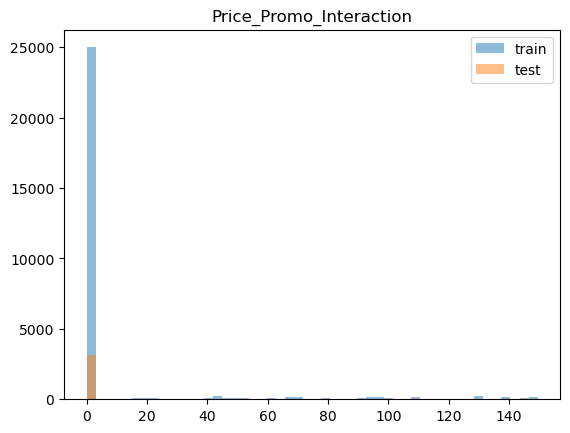

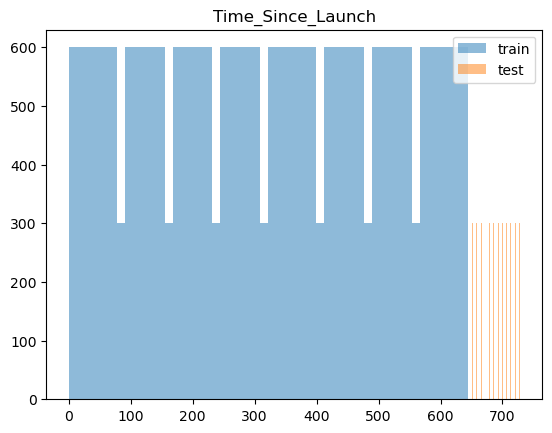

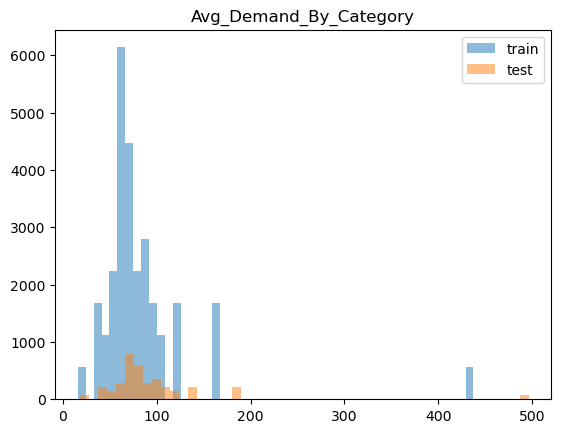

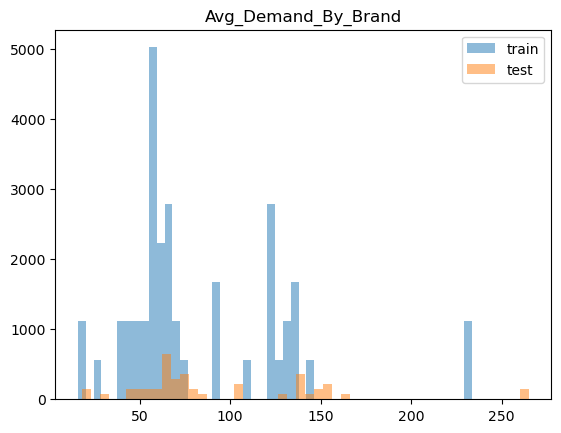

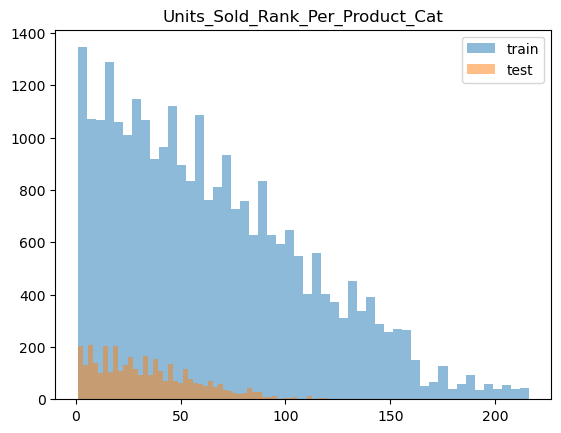

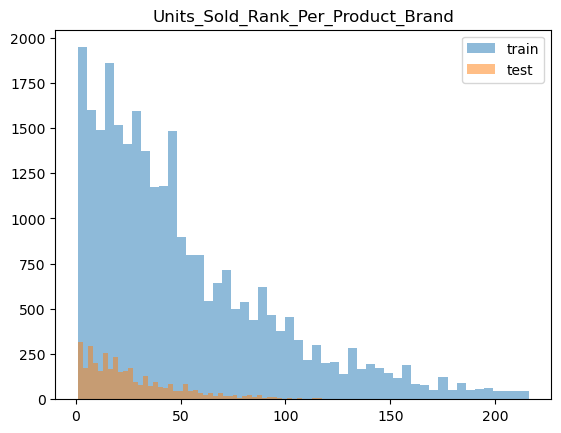

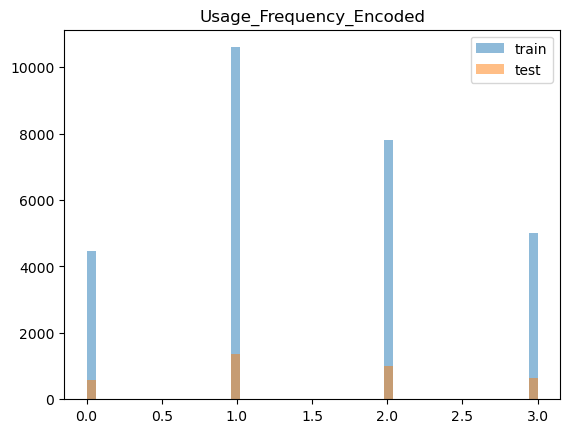

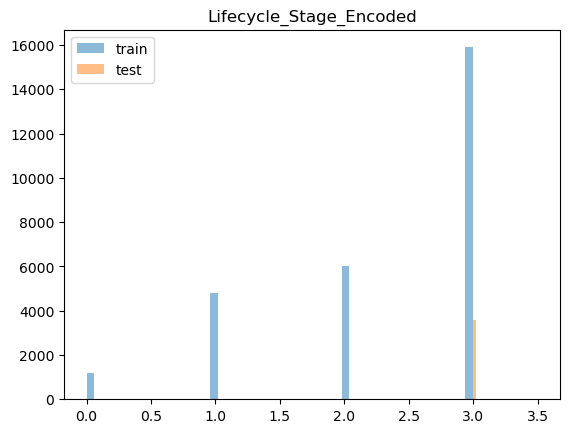

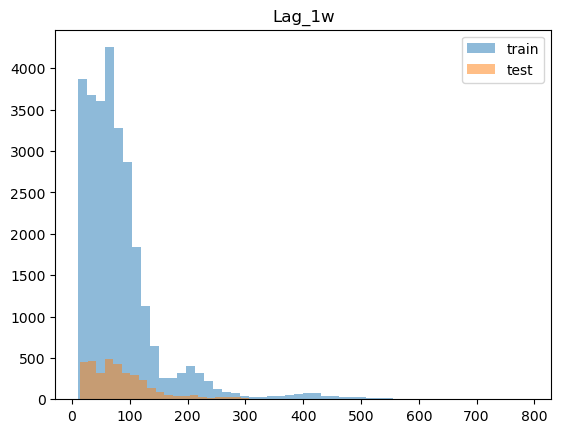

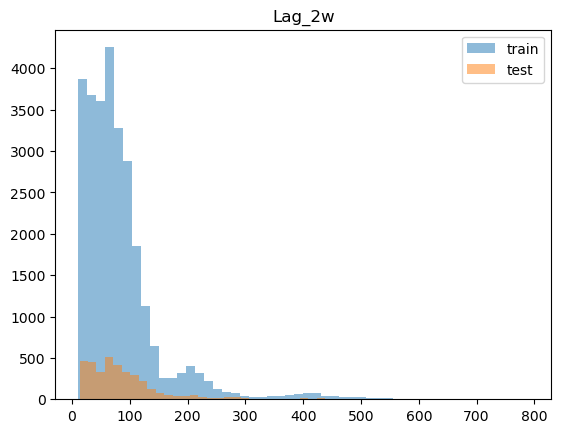

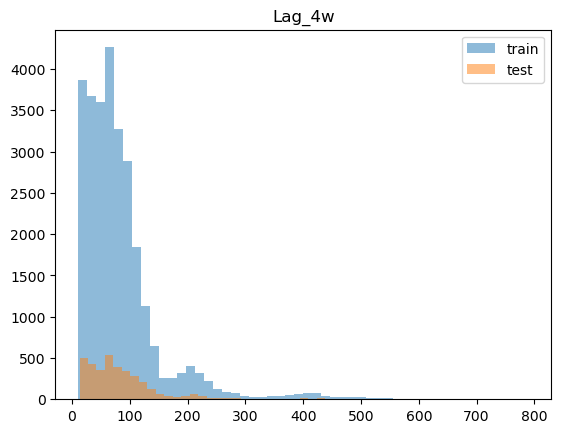

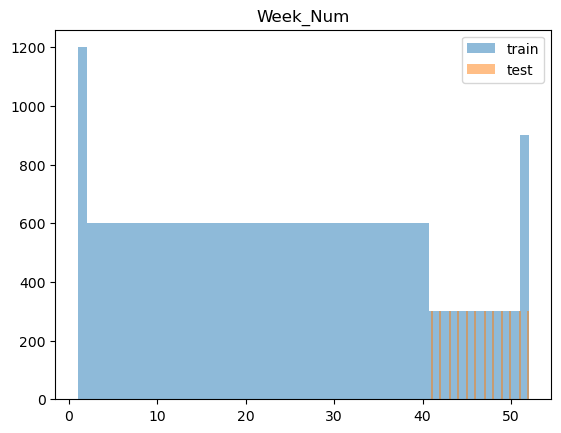

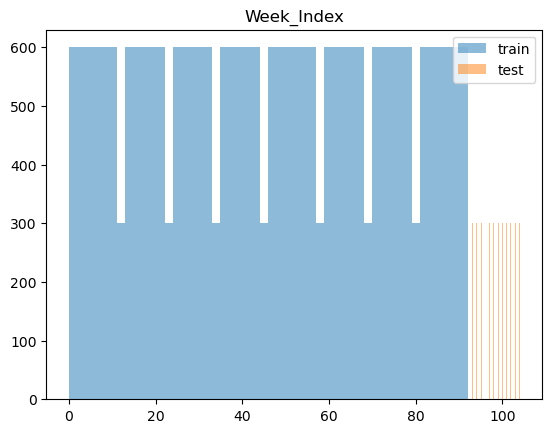

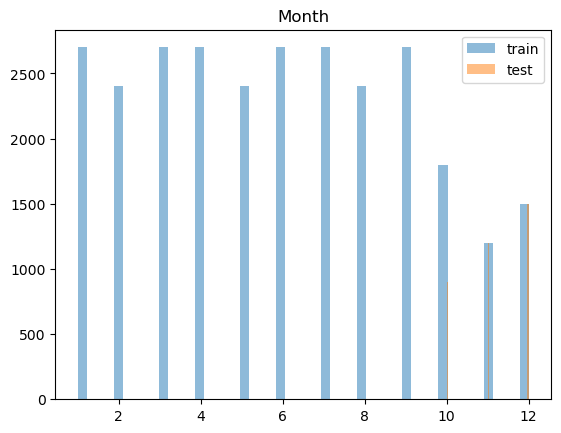

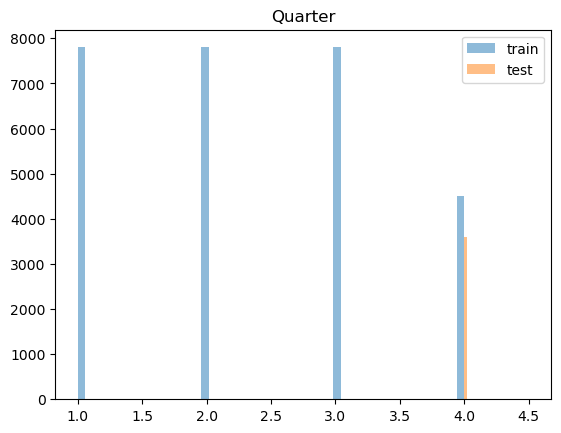

In [146]:
num_cols = ['Price_USD', 'Rating', 'Promo_Lift',
    'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 'Time_Since_Launch',
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
    'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'Lag_1w', 'Lag_2w', 'Lag_4w',
    'Week_Num', 'Week_Index', 'Month', 'Quarter']

for col in num_cols:
    plt.hist(train_start[col], bins=50, alpha=0.5, label='train')
    plt.hist(test_start[col], bins=50, alpha=0.5, label='test')
    plt.title(col)
    plt.legend()
    plt.show()

### Basic encodings

#### Frequency encoding

In [147]:
# Frequency encoding higher-cardinality categoricals (Brand: 30, Category: 21, Product_Name: 42)

brand_freq = train_start["Brand"].value_counts(normalize=True)
train_start["Brand_FE"] = train_start["Brand"].map(brand_freq)
test_start["Brand_FE"] = test_start["Brand"].map(brand_freq).fillna(brand_freq.mean())  # fill unseen brands with 0

category_freq = train_start["Category"].value_counts(normalize=True)
train_start["Category_FE"] = train_start["Category"].map(category_freq)
test_start["Category_FE"] = test_start["Category"].map(category_freq).fillna(category_freq.mean())

name_freq = train_start["Product_Name"].value_counts(normalize=True)
train_start["Name_FE"] = train_start["Product_Name"].map(name_freq)
test_start["Name_FE"] = test_start["Product_Name"].map(name_freq).fillna(name_freq.mean())

In [148]:
print(train_start.shape)
print(test_start.shape)

(27900, 46)
(3600, 46)


#### Cyclical Features

In [149]:
# Handling Cyclical Features
#Month
train_start["Month_sin"] = np.sin(2 * np.pi * train_start["Month"].astype(int) / 12)
train_start["Month_cos"] = np.cos(2 * np.pi * train_start["Month"].astype(int) / 12)
test_start["Month_sin"] = np.sin(2 * np.pi * test_start["Month"].astype(int) / 12)
test_start["Month_cos"] = np.cos(2 * np.pi * test_start["Month"].astype(int) / 12)

# Week_Num 
train_start['Week_sin'] = np.sin(2 * np.pi * train_start['Week_Num'] / 52)
train_start['Week_cos'] = np.cos(2 * np.pi * train_start['Week_Num'] / 52)
test_start['Week_sin'] = np.sin(2 * np.pi * test_start['Week_Num'] / 52)
test_start['Week_cos'] = np.cos(2 * np.pi * test_start['Week_Num'] / 52)

#Quarter
train_start['Quarter_sin'] = np.sin(2 * np.pi * train_start['Quarter'] / 4)
train_start['Quarter_cos'] = np.cos(2 * np.pi * train_start['Quarter'] / 4)
test_start['Quarter_sin'] = np.sin(2 * np.pi * test_start['Quarter'] / 4)
test_start['Quarter_cos'] = np.cos(2 * np.pi * test_start['Quarter'] / 4)

In [150]:
print(train_start.shape)
print(test_start.shape)

(27900, 52)
(3600, 52)


In [151]:
train_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27900 entries, 0 to 27899
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Pseudo_SKU_ID                      27900 non-null  object        
 1   Product_ID                         27900 non-null  int64         
 2   Product_Name                       27900 non-null  object        
 3   Brand                              27900 non-null  object        
 4   Category                           27900 non-null  object        
 5   Region                             27900 non-null  object        
 6   Channel                            27900 non-null  object        
 7   Date                               27900 non-null  datetime64[ns]
 8   Week_Num                           27900 non-null  int64         
 9   Units_Sold                         27900 non-null  int64         
 10  Promotion_Flag                    

#### Saving Encoded Data

In [152]:
# Saving encoded datasets
train_encoded = train_start.copy()
test_encoded = test_start.copy()

# Sorting by Date and ID
train_encoded = train_encoded.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)
test_encoded = test_encoded.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)

train_encoded.to_parquet("../data/train_encoded.parquet")
test_encoded.to_parquet("../data/test_encoded.parquet")

In [153]:
print(train_encoded.shape)
print(test_encoded.shape)

(27900, 52)
(3600, 52)


In [154]:
num_cols = train_encoded.select_dtypes(include=np.number).columns.tolist()
cat_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = train_encoded.select_dtypes(include='bool').columns
datetime_cols = train_encoded.select_dtypes(include=['datetime64']).columns.tolist()
string_cols = train_encoded.select_dtypes(include='string').columns.tolist()

print('Numeric columns:', num_cols)
print('--------')
print('Categorical columns:', cat_cols)
print('--------')
print('Boolean columns:', bool_cols.tolist())
print('--------')
print('Datetime columns:', datetime_cols)
print('--------')
print('String columns:', string_cols)

Numeric columns: ['Product_ID', 'Week_Num', 'Units_Sold', 'Promotion_Flag', 'Is_New_Launch', 'Price_USD', 'Rating', 'Cruelty_Free', 'Week_Index', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded', 'Demand_Cluster', 'Promo_Lift', 'Month', 'Quarter', 'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w', 'Price_Promo_Interaction', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Time_Since_Launch', 'Avg_Demand_By_Category', 'Avg_Demand_By_Brand', 'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand', 'Units_Sold_Log', 'Brand_FE', 'Category_FE', 'Name_FE', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos']
--------
Categorical columns: ['Pseudo_SKU_ID', 'Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage', 'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin', 'Demand_Label']
--------
Boolean columns: []
--------
Datetime columns: ['Date']
--------
String columns: []


In [155]:
# Column types for train_encoded
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
date_col = ['Date']
bool_cols = ['Promotion_Flag', 'Is_New_Launch', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Cruelty_Free']
numeric_cols = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 'Time_Since_Launch', 'Promo_Lift',
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
    'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos'
    'Week_Num', 'Week_Index', 'Month', 'Quarter']
encoded_cat_cols = ['Brand_FE', 'Category_FE', 'Name_FE', 'Demand_Cluster']
cat_cols = [
    'Product_Name', 'Brand', 'Category', 'Region', 'Channel', 'Lifecycle_Stage',
    'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Country_of_Origin',
    'Demand_Label']

### Dropping features

In [156]:
# Dropping unnecessary features
train_reduced = train_start.drop(columns=['Week_Num', 'Week_Index', 'Units_Sold', 'Month', 'Quarter', 'Product_Name', 'Brand', 'Category', 'Lifecycle_Stage',
                                               'Usage_Frequency', 'Demand_Label'])
test_reduced = test_start.drop(columns=['Week_Num', 'Units_Sold', 'Month', 'Quarter', 'Product_Name', 'Brand', 'Category', 'Lifecycle_Stage', 
                                 'Usage_Frequency', 'Demand_Label'])

In [157]:
print(train_reduced.shape)
print(test_reduced.shape)

(27900, 41)
(3600, 42)


In [158]:
num_cols = train_reduced.select_dtypes(include=np.number).columns.tolist()
cat_cols = train_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = train_reduced.select_dtypes(include='bool').columns
datetime_cols = train_reduced.select_dtypes(include=['datetime64']).columns.tolist()
string_cols = train_reduced.select_dtypes(include='string').columns.tolist()

print('Numeric columns:', num_cols)
print('--------')
print('Categorical columns:', cat_cols)
print('--------')
print('Boolean columns:', bool_cols.tolist())
print('--------')
print('Datetime columns:', datetime_cols)
print('--------')
print('String columns:', string_cols)

Numeric columns: ['Product_ID', 'Promotion_Flag', 'Is_New_Launch', 'Price_USD', 'Rating', 'Cruelty_Free', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded', 'Demand_Cluster', 'Promo_Lift', 'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w', 'Price_Promo_Interaction', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Time_Since_Launch', 'Avg_Demand_By_Category', 'Avg_Demand_By_Brand', 'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand', 'Units_Sold_Log', 'Brand_FE', 'Category_FE', 'Name_FE', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos']
--------
Categorical columns: ['Pseudo_SKU_ID', 'Region', 'Channel', 'Skin_Type', 'Gender_Target', 'Country_of_Origin']
--------
Boolean columns: []
--------
Datetime columns: ['Date']
--------
String columns: []


In [159]:
#Column types for train_reduced
id_cols = ['Pseudo_SKU_ID', 'Product_ID']
target_col = "Units_Sold_Log"
date_col = ['Date']
encoded_bool_cols = ['Promotion_Flag', 'Is_New_Launch', 'Is_Holiday_Season', 'Is_MidYear_Lift', 'Cruelty_Free']
encoded_cat_cols = ['Brand_FE', 'Category_FE', 'Name_FE']
cat_cols = ['Region', 'Channel', 'Skin_Type', 'Gender_Target', 'Country_of_Origin']
num_cols = [
    'Price_USD', 'Rating', 'Usage_Frequency_Encoded', 'Lifecycle_Stage_Encoded',
    'Lag_1w', 'Lag_2w', 'Lag_4w', 'RollingMean_4w', 'RollingStd_4w', 'Lag_Diff_1w',
    'Price_Promo_Interaction', 'Time_Since_Launch',
    'Avg_Demand_By_Category', 'Avg_Demand_By_Brand',
    'Units_Sold_Rank_Per_Product_Cat', 'Units_Sold_Rank_Per_Product_Brand',
    'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos']

## <span style="color:blue">6. FINAL STEPS</span>

### Final Steps

In [160]:
# Check for missing values
print("Train missing values:\n", train_reduced.isnull().sum()[train_reduced.isnull().sum() > 0])
print("Test missing values:\n", test_reduced.isnull().sum()[test_reduced.isnull().sum() > 0])

Train missing values:
 Series([], dtype: int64)
Test missing values:
 Series([], dtype: int64)


In [161]:
# Check shape
print("Train shape:\n", train_reduced.shape)
print("Test shape:\n", test_reduced.shape)

Train shape:
 (27900, 41)
Test shape:
 (3600, 42)


In [162]:
# Sorting by Date and ID
train_reduced = train_reduced.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)
test_reduced  = test_reduced.sort_values(by=['Pseudo_SKU_ID', 'Date']).reset_index(drop=True)

### Final Datasets and Saved Data

In [94]:
# train_reduced.to_parquet("../data/train_reduced.parquet", index=False)
# test_reduced.to_parquet("../data/test_reduced.parquet", index=False)

## Project 1 Complete: EDA & Preprocessing

Ready to proceed to Project 2: Modeling & Forecasting.

#### Author  
*Eszter Varga – Data Scientist*  
*GitHub: Timensider*  

*Worked through this project independently, collaborating with AI tools and documentation along the way — just as I would in a real-world workflow.*